In [223]:
import neo
# general parameters
from vor_cerebellum.parameters import (CONNECTIVITY_MAP, rbls, neuron_params)
# MF-VN params
from vor_cerebellum.parameters import (mfvn_min_weight, mfvn_max_weight,
                                       mfvn_initial_weight,
                                       mfvn_ltp_constant,
                                       mfvn_beta, mfvn_sigma)
# PF-PC params
from vor_cerebellum.parameters import (pfpc_min_weight, pfpc_max_weight,
                                       pfpc_initial_weight,
                                       pfpc_ltp_constant, pfpc_t_peak)
from vor_cerebellum.utilities import *
import os
import elephant
import traceback
import neo
import quantities as pq
from pyNN.utility.plotting import Figure, Panel
from brian2.units import ms, Hz
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid

In [224]:
%matplotlib inline

In [225]:
def compute_spikes_per_timestep(all_spikes, plot_order):
    spikes_per_timestep = {}

    for pop in plot_order:
        spikes = all_spikes[pop]

        spikes_per_timestep[pop] = \
            np.bincount((spikes[:, 1] * time_to_bin_conversion).astype(int),
                        minlength=no_timesteps)
    return spikes_per_timestep

# https://stackoverflow.com/questions/56654952/how-to-mark-cells-in-matplotlib-pyplot-imshow-drawing-cell-borders
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x, y), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

def highlight_column(x,y, height, ax=None, **kwargs):
    rect = plt.Rectangle((x, y), 1, height, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

def compute_isi_distribution(spikes, n_neurons):
    isis = []
    for n in np.arange(n_neurons):
        isis.append(np.ediff1d(np.sort(spikes[spikes[:, 0]==n][:, 1])))
#         isis[0].append(np.array(elephant.statistics.isi(
#                 p1 / pq.ms
#             )))
    return isis

def compute_isi(spikes, n_neurons):
    isis = np.ones(n_neurons) * np.nan
    for n in np.arange(n_neurons):
        isis[n] = np.mean(np.ediff1d(spikes[spikes[:, 0]==n][:, 1]))
    return isis

def closest_ioffset_index(value, dc_currents):
    diffs = dc_currents - value
    argmin = np.argmin(np.abs(diffs))
    return argmin

def count_spikes_per_neuron(spikes):
    nids = np.unique(spikes[:, 0]).astype(int)
    if len(nids)==0:
        spike_counts = np.zeros(1)
    else:
        spike_counts = np.zeros(np.max(nids)+1)
    for n in nids:
        spike_counts[n] = spikes[spikes[:, 0]==n].shape[0]
    return spike_counts

def compute_lead_or_lag_per_neuron(spikes_1, spikes_2, nth_spike):
    nids = np.unique(spikes_1[:, 0]).astype(int)
    if len(nids)==0:
        spike_lead_lag = np.ones(1) * np.nan
    else:
        spike_lead_lag = np.ones(np.max(nids)+1) * np.nan
    for n in nids:
        filtered_spikes_1 = np.sort(spikes_1[spikes_1[:, 0]==n][:, 1])
        filtered_spikes_2 = np.sort(spikes_2[spikes_2[:, 0]==n][:, 1])
        if filtered_spikes_1.size < nth_spike or filtered_spikes_2.size < nth_spike:
            spike_lead_lag[n] = np.nan
        else:
            spike_lead_lag[n] = np.round(filtered_spikes_1[nth_spike-1], 1) - np.round((filtered_spikes_2[nth_spike-1] - 0.1), 1)
    return spike_lead_lag

def plot_imshow_diff_map(diff_map, plot_order, dc_currents, subcycles, xlabel, cmap_label, fig_name, fig_folder, vmax=None, vmin=None, rotation=90):
    camera_ready_dc = ["{}".format(x) for x in case_names]
    camera_ready_pops = [use_display_name(x) for x in plot_order]
    n_pops = len(plot_order)
    n_sc = len(subcycles)
    n_dc = len(dc_currents)
    
    f = plt.figure(1, figsize=(7, 7), dpi=500)
    im = plt.imshow(diff_map[:, dc_currents], interpolation='none', vmax=vmax, vmin=vmin,
                    extent=[0, dc_currents.size, (n_sc) * n_pops, 0],
                    origin='upper')
    ax = plt.gca()
    ax.set_aspect('auto')
    plt.xlabel(xlabel)
    plt.ylabel("Population")

    plt.xticks(np.arange(dc_currents.size) + .5, camera_ready_dc)
    plt.yticks(np.arange(len(camera_ready_pops))*n_sc + (n_sc/2.) - .5, camera_ready_pops, rotation=rotation, va='center')
    ax.yaxis.set_minor_locator(FixedLocator(np.arange(len(camera_ready_pops))*n_sc))
    ax.xaxis.set_minor_locator(FixedLocator(np.arange(len(dc_currents))))
    
    plt.grid(b=True, which='minor', color='k', linestyle='-', linewidth=1)
#     for p_id, po in enumerate(plot_order):
#         closest = closest_used_dc_current[po]
#         highlight_column(closest, p_id * n_sc, n_sc, color="white", linewidth=1, zorder=4)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", "5%", pad="3%")
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(cmap_label)

    save_figure(plt, os.path.join(fig_folder,
                          fig_name),
                extensions=['.png', '.pdf'])
    plt.show()
    plt.close(f)
    
    
def plot_raster_and_psth(all_spikes, plot_order, suffix=None):
    n_plots = len(plot_order)
    spikes_per_timestep = compute_spikes_per_timestep(all_spikes, plot_order)
    print("Plotting spiking raster plot + PSTH for all populations")
    f, axes = plt.subplots(2 * len(all_spikes.keys()), 1,
                           figsize=(20, 30), sharex=True, dpi=300)
    for index, pop in enumerate(np.repeat(plot_order, 2)):
        curr_ax = axes[index]
        if index % 2 == 0:
            # spike raster
            _times = all_spikes[pop][:, 1]
            _ids = all_spikes[pop][:, 0]
            curr_ax.scatter(_times,
                            _ids,
                            color=viridis_cmap(int(index / 2) / (n_plots + 1)),
                            s=.5, rasterized=True)
            curr_ax.set_title(use_display_name(pop))
            curr_ax.set_ylabel("NID")
        else:
            curr_ax.bar(np.arange(spikes_per_timestep[pop].size) * timestep / ms,
                        spikes_per_timestep[pop],
                        color=viridis_cmap(int(index / 2) / (n_plots + 1)),
                        rasterized=True)
            curr_ax.set_ylabel("Count")

    plt.xlabel("Time (ms)")
    # plt.suptitle((use_display_name(simulator) + "\n")
    f.tight_layout()
    plt.xlim([0, 500])
    file_out_name = "raster_and_psth_plots"
    if suffix is not None:
        file_out_name += "_" + suffix
    plt.show()
    save_figure(plt, file_out_name,
                extensions=['.png', ])
    plt.close(f)
    
def report_best_values(diff_map, plot_order, cases, subcycles, v1=None, v2=None):
    n_pops = len(plot_order)
    n_sc = len(subcycles)
    n_cases = len(cases)
    for pop_id, pop in enumerate(plot_order):
        curr_pop_diff_slice = diff_map[pop_id*n_sc:(pop_id+1)*n_sc]
        assert curr_pop_diff_slice.shape[0] == n_sc
        assert curr_pop_diff_slice.shape[1] == n_cases
        print("For POP", pop)
        vals = []
        comp_vals = []
        for cid, case in enumerate(cases):
            case_slice = curr_pop_diff_slice[:, cid]
            best_for_case = np.argmin(np.abs(case_slice))
            curr_val = np.round(case_slice[best_for_case],2)
            if v1 is not None and v2 is not None:
                comp_vals.append([v1[pop_id*n_sc:(pop_id+1)*n_sc, cid][best_for_case], 
                                  v2[pop_id*n_sc:(pop_id+1)*n_sc, cid][best_for_case]])
            vals.append(curr_val)
            print("\tthe best for case", case,  "is", curr_val, "achieved for sc", subcycles[best_for_case])
        form_string = "& {}"*len(vals)
        print("AGAIN, pop", pop, form_string.format(*vals))
        if v1 is not None and v2 is not None:
            for cid, cv in enumerate(comp_vals):
                cv /= (simtime * ms)
                print("DIFF, pop", pop, "case", cid, form_string.format(*cv), "& diff=", (cv[0]-cv[1])/Hz)

def plot_voltage(vs, baseline_vs, population, subcycles, dc_index, dc_currents, xlim=[0, 500], 
                 y_label="Membrane potential (mV)", baseline_2_vs=None, baseline_names=None
                ):
    n_plots = len(subcycles)
    plt.figure(figsize=(8, 5), dpi=300)
    plt.title("{} {}".format(use_display_name(population), dc_currents[dc_index]))
    for index, sc in enumerate(subcycles):
        data = vs[sc][dc_index][population][0]
        plt.plot(np.arange(data.size)*0.1*ms, data, 
                            color=viridis_cmap(index / (n_plots + 1)),
                 label="{} sub-cycles".format(sc) if sc != 1 else "{} sub-cycle".format(sc), 
                 alpha=.8
                )
    baseline_data = baseline_vs[1][dc_index][population][0]
    
    baseline_1_name = baseline_names[0] if baseline_names is not None else "Baseline"
    baseline_2_name = baseline_names[1] if baseline_names is not None else "Baseline 2"
    
    plt.plot(np.arange(baseline_data.size)*0.1*ms, baseline_data, 
                            color="k",
                 label=baseline_1_name,
                 linestyle=":",
                 alpha=.6
                )
    
    if baseline_2_vs is not None:
        baseline_data_2 = baseline_2_vs[1][dc_index][population][0]
        plt.plot(np.arange(baseline_data_2.size)*0.1*ms, baseline_data_2, 
                            color="grey",
                 label=baseline_2_name,
                 linestyle="-.",
                 alpha=.8
                )
    plt.ylabel(y_label)
    plt.xlabel("Time (s)")
    plt.xlim(xlim)
    plt.legend(loc='best')
    
def plot_assortment(pop, subcycles, case, case_names=case_names, xlim=[0, 500]):
    plot_voltage(vs, baseline_vs, population=pop, subcycles=subcycles, dc_index=case, dc_currents=case_names, xlim=xlim)
    plot_voltage(gsyn_excs, baseline_gsyn_excs, population=pop, subcycles=subcycles, dc_index=case, dc_currents=case_names, xlim=xlim, y_label="Exc syn conductance (nS)")
    plot_voltage(gsyn_inhs, baseline_gsyn_inhs, population=pop, subcycles=subcycles, dc_index=case, dc_currents=case_names, xlim=xlim, y_label="Inh syn conductance (nS)")
    
def plot_by_case(signal, baseline_signal, plot_order, subcycles, cases, y_label, xlim=[0, .1], 
                 baseline_2_signal=None, baseline_names=None):
    n_rows = len(plot_order)
    n_columns = len(cases)
    n_plots = len(subcycles)
    sc = 1
    sc_index=0
    
    lw = .8
    
    
    baseline_1_name = baseline_names[0] if baseline_names is not None else "Baseline"
    baseline_2_name = baseline_names[1] if baseline_names is not None else "Baseline 2"
    
    f, axes = plt.subplots(n_rows, n_columns, figsize=(6, 9), dpi=400, sharex='row', sharey='row')
    for index, pop in enumerate(plot_order):
        curr_axs = axes[index]
        
        curr_axs[0].set_ylabel(use_display_name(pop) + "\n" + y_label)
        for case_col, case in enumerate(cases):
            # Data stuff           
            data = signal[case][pop]
            if n_plots == 1:
                label = "SpiNNaker"
            else:
                label = "{} sub-cycles".format(sc) if sc != 1 else "{} sub-cycle".format(sc)
            curr_axs[case_col].plot(np.arange(data.size)*1.0*ms, data.ravel(), 
                        color=viridis_cmap(sc_index / (n_plots + 1)),
             label=label, 
             alpha=.8, rasterized=True, linewidth=lw
            )
            curr_axs[case_col].set_xlim(xlim)
            curr_axs[case_col].set_aspect('auto')
                
            baseline_data = baseline_signal[case][pop]
            curr_axs[case_col].plot(np.arange(baseline_data.size)*1.0*ms, baseline_data.ravel(), 
                                    color="k",
                         label=baseline_1_name,
                         linestyle=":",
                         alpha=.6, rasterized=True, linewidth=lw
                        )

            # admin stuff
            if index==0:
                curr_axs[case_col].set_title("{}".format(case_names[case]))
                if case_col==0:
                    curr_axs[0].legend(loc='best')
            if index==n_rows-1:
                curr_axs[case_col].set_xlabel("Time (s)")
                curr_axs[case_col].xaxis.set_visible(True)
    
#                 plt.xlabel("Time (s)")
            else:
                labels = [item.get_text() for item in curr_axs[case_col].get_xticklabels()]
                empty_string_labels = ['']*len(labels)
                curr_axs[case_col].set_xticklabels(empty_string_labels)
#     plt.subplots_adjust(wspace=-.1, hspace=0)
    save_figure(plt, "ICUB_VOR_single_vs_max_spikes", extensions=['.png', '.pdf', ])
    plt.show()
    

In [226]:
path_to_results = "/localhome/mbax3pb2/anaconda3/envs/icub_vor_spinnaker/spinnaker/vor_cerebellum/vor_cerebellum/generic_tests/results/"


filename = os.path.join(path_to_results, "spinnaker_testing_neurons.npz")
baseline_filename = os.path.join(path_to_results, "nest_testing_neurons.npz")

data = np.load(filename, allow_pickle=True)
baseline_data = np.load(baseline_filename, allow_pickle=True)
print(filename, data.files)
print(baseline_filename, baseline_data.files)

/localhome/mbax3pb2/anaconda3/envs/icub_vor_spinnaker/spinnaker/vor_cerebellum/vor_cerebellum/generic_tests/results/spinnaker_testing_neurons.npz ['all_connections', 'spikes', 'v', 'gsyn_exc', 'gsyn_inh', 'no_packets', 'low_rec_spikes', 'high_rec_spikes', 'input_spikes', 'simtime', 'cases', 'case_names']
/localhome/mbax3pb2/anaconda3/envs/icub_vor_spinnaker/spinnaker/vor_cerebellum/vor_cerebellum/generic_tests/results/nest_testing_neurons.npz ['all_connections', 'spikes', 'v', 'gsyn_exc', 'gsyn_inh', 'no_packets', 'low_rec_spikes', 'high_rec_spikes', 'input_spikes', 'simtime', 'cases', 'case_names']


In [227]:
spikes=data['spikes'].ravel()[0]
vs=data['v'].ravel()[0]
gsyn_excs=data['gsyn_exc'].ravel()[0]
gsyn_inhs=data['gsyn_inh'].ravel()[0]
no_packets=data['no_packets'].ravel()[0]
all_connections = data['all_connections'].ravel()[0]
low_rec_spikes = data['low_rec_spikes'].ravel()[0]
high_rec_spikes = data['high_rec_spikes'].ravel()[0]
input_spikes = data['input_spikes'].ravel()[0]

cases = data['cases']
case_names = data['case_names']
simtime = data['simtime']

In [228]:
baseline_spikes=baseline_data['spikes'].ravel()[0]
baseline_vs=baseline_data['v'].ravel()[0]
baseline_gsyn_excs=baseline_data['gsyn_exc'].ravel()[0]
baseline_gsyn_inhs=baseline_data['gsyn_inh'].ravel()[0]
baseline_no_packets=baseline_data['no_packets'].ravel()[0]
baseline_all_connections = baseline_data['all_connections'].ravel()[0]
baseline_low_rec_spikes = baseline_data['low_rec_spikes'].ravel()[0]
baseline_high_rec_spikes = baseline_data['high_rec_spikes'].ravel()[0]
baseline_input_spikes = baseline_data['input_spikes'].ravel()[0]

baseline_cases = baseline_data['cases']
baseline_case_names = baseline_data['case_names']
baseline_simtime = baseline_data['simtime']

In [229]:
assert np.all(cases == baseline_cases)
assert simtime == baseline_simtime

In [230]:
plot_order = get_plot_order(spikes[0].keys())
timestep = 1 * ms
# Pre-compute conversions
time_to_bin_conversion = 1. / (timestep / ms)
bins_in_3ms = int(3 * time_to_bin_conversion)
no_timesteps = int(simtime / ms * time_to_bin_conversion)
pad_to_compute_3ms_bins = bins_in_3ms - no_timesteps % bins_in_3ms

# left-overs from SpiNNCer
subcycles = [1]

Plot order: ['cf_pc', 'goc_grc', 'mf_goc', 'mf_grc', 'mf_vn', 'pc_vn', 'pf_pc']


# Simplest checks first: are we stimulating the neurons with exactly the same spikes?

In [231]:
x = np.array(low_rec_spikes.segments[0].spiketrains)
base_x = np.array(baseline_low_rec_spikes.segments[0].spiketrains)
diff = x-base_x
for st in diff:
    assert np.all(st/pq.ms==0)

In [232]:
x = np.array(high_rec_spikes.segments[0].spiketrains)
base_x = np.array(baseline_high_rec_spikes.segments[0].spiketrains)
diff = x-base_x
for st in diff:
    assert np.all(st/pq.ms==0)

# Check \#2: spike counts

In [233]:
empirical_rates={}

for case, pop_spikes in input_spikes.items():
    print(case_names[case], case)
    empirical_rates[case] = {k:0 for k in pop_spikes.keys()}
    for pop_name, pop_spike in pop_spikes.items():            
        for spiketrain in pop_spike:
            if type(spiketrain) == float:
                empirical_rates[case][pop_name] += 1
            else:
                empirical_rates[case][pop_name] += len(spiketrain)
            
empirical_rates

Low 0
High 1


{0: {'cf_pc': 966,
  'goc_grc': 966,
  'mf_goc': 966,
  'mf_grc': 966,
  'mf_vn': 966,
  'pc_vn': 966,
  'pf_pc': 966},
 1: {'cf_pc': 12153,
  'goc_grc': 12153,
  'mf_goc': 12153,
  'mf_grc': 12153,
  'mf_vn': 12153,
  'pc_vn': 12153,
  'pf_pc': 12153}}

In [234]:
plot_order = get_plot_order(spikes[0].keys())
# Pre-compute conversions
time_to_bin_conversion = 1. / (timestep / ms)
bins_in_3ms = int(3 * time_to_bin_conversion)
no_timesteps = int(simtime / ms * time_to_bin_conversion)
pad_to_compute_3ms_bins = bins_in_3ms - no_timesteps % bins_in_3ms

Plot order: ['cf_pc', 'goc_grc', 'mf_goc', 'mf_grc', 'mf_vn', 'pc_vn', 'pf_pc']


In [235]:
n_pops = len(plot_order)
n_cases = len(cases)
n_sc = 1
sc = 0

diff_map = np.ones((n_pops, n_cases)) * np.nan
diff_map_2 = np.ones((n_pops, n_cases)) * np.nan


baseline_diff_map = np.ones((n_pops, n_cases)) * np.nan
baseline_spike_lead_lag_map_10th = np.ones((n_pops, n_cases)) * np.nan
baseline_spike_lead_lag_map_100th = np.ones((n_pops, n_cases)) * np.nan

spike_lead_lag_map_10th = np.ones((n_pops, n_cases)) * np.nan
spike_lead_lag_map_100th = np.ones((n_pops, n_cases)) * np.nan
spike_lead_lag_map_1st = np.ones((n_pops, n_cases)) * np.nan

spike_count_map_baseline = np.ones((n_pops, n_cases)) * np.nan

spike_count_map = np.ones((n_pops, n_cases)) * np.nan

isi_map = np.ones((n_pops, n_cases)) * np.nan
baseline_isi_map = np.ones((n_pops, n_cases)) * np.nan

diff_isi_map = np.ones((n_pops*n_sc, n_cases)) * np.nan

for case in cases:
    for index, pop in enumerate(plot_order):
        # y position should be dictated by population index and sc 
        comp_spike_count = count_spikes_per_neuron(spikes[case][pop])
        baseline_spike_count = count_spikes_per_neuron(baseline_spikes[case][pop])

        diff_map[index*n_sc + (sc-1), case] = comp_spike_count - baseline_spike_count  

        isi_map[index*n_sc + (sc-1), case] = compute_isi(spikes[case][pop], n_neurons=1)
        baseline_isi_map[index*n_sc + (sc-1), case] = compute_isi(baseline_spikes[case][pop], n_neurons=1)

        spike_count_map_baseline[index*n_sc + (sc-1), case] = baseline_spike_count
        spike_count_map[index*n_sc + (sc-1), case] = comp_spike_count

        spike_lead_lag_map_10th[index*n_sc + (sc-1), case] = compute_lead_or_lag_per_neuron(spikes[case][pop], baseline_spikes[case][pop], 10)
        spike_lead_lag_map_100th[index*n_sc + (sc-1), case] = compute_lead_or_lag_per_neuron(spikes[case][pop], baseline_spikes[case][pop], 100)
        spike_lead_lag_map_1st[index*n_sc + (sc-1), case] = compute_lead_or_lag_per_neuron(spikes[case][pop], baseline_spikes[case][pop], 1)

diff_isi_map = isi_map - baseline_isi_map        
max_firing_rate = np.max((spike_count_map_baseline, spike_count_map)) / (simtime * ms)

In [236]:
print("Min diff", np.min(diff_map))
print("Max diff", np.max(diff_map))
print("Max firing rate", max_firing_rate)

Min diff -499.0
Max diff 98.0
Max firing rate 0.499 kHz


Plotting                                :figures/ICUB_VOR_spikes_baseline_firing_rate_map.png
Plotting                                :figures/ICUB_VOR_spikes_baseline_firing_rate_map.pdf


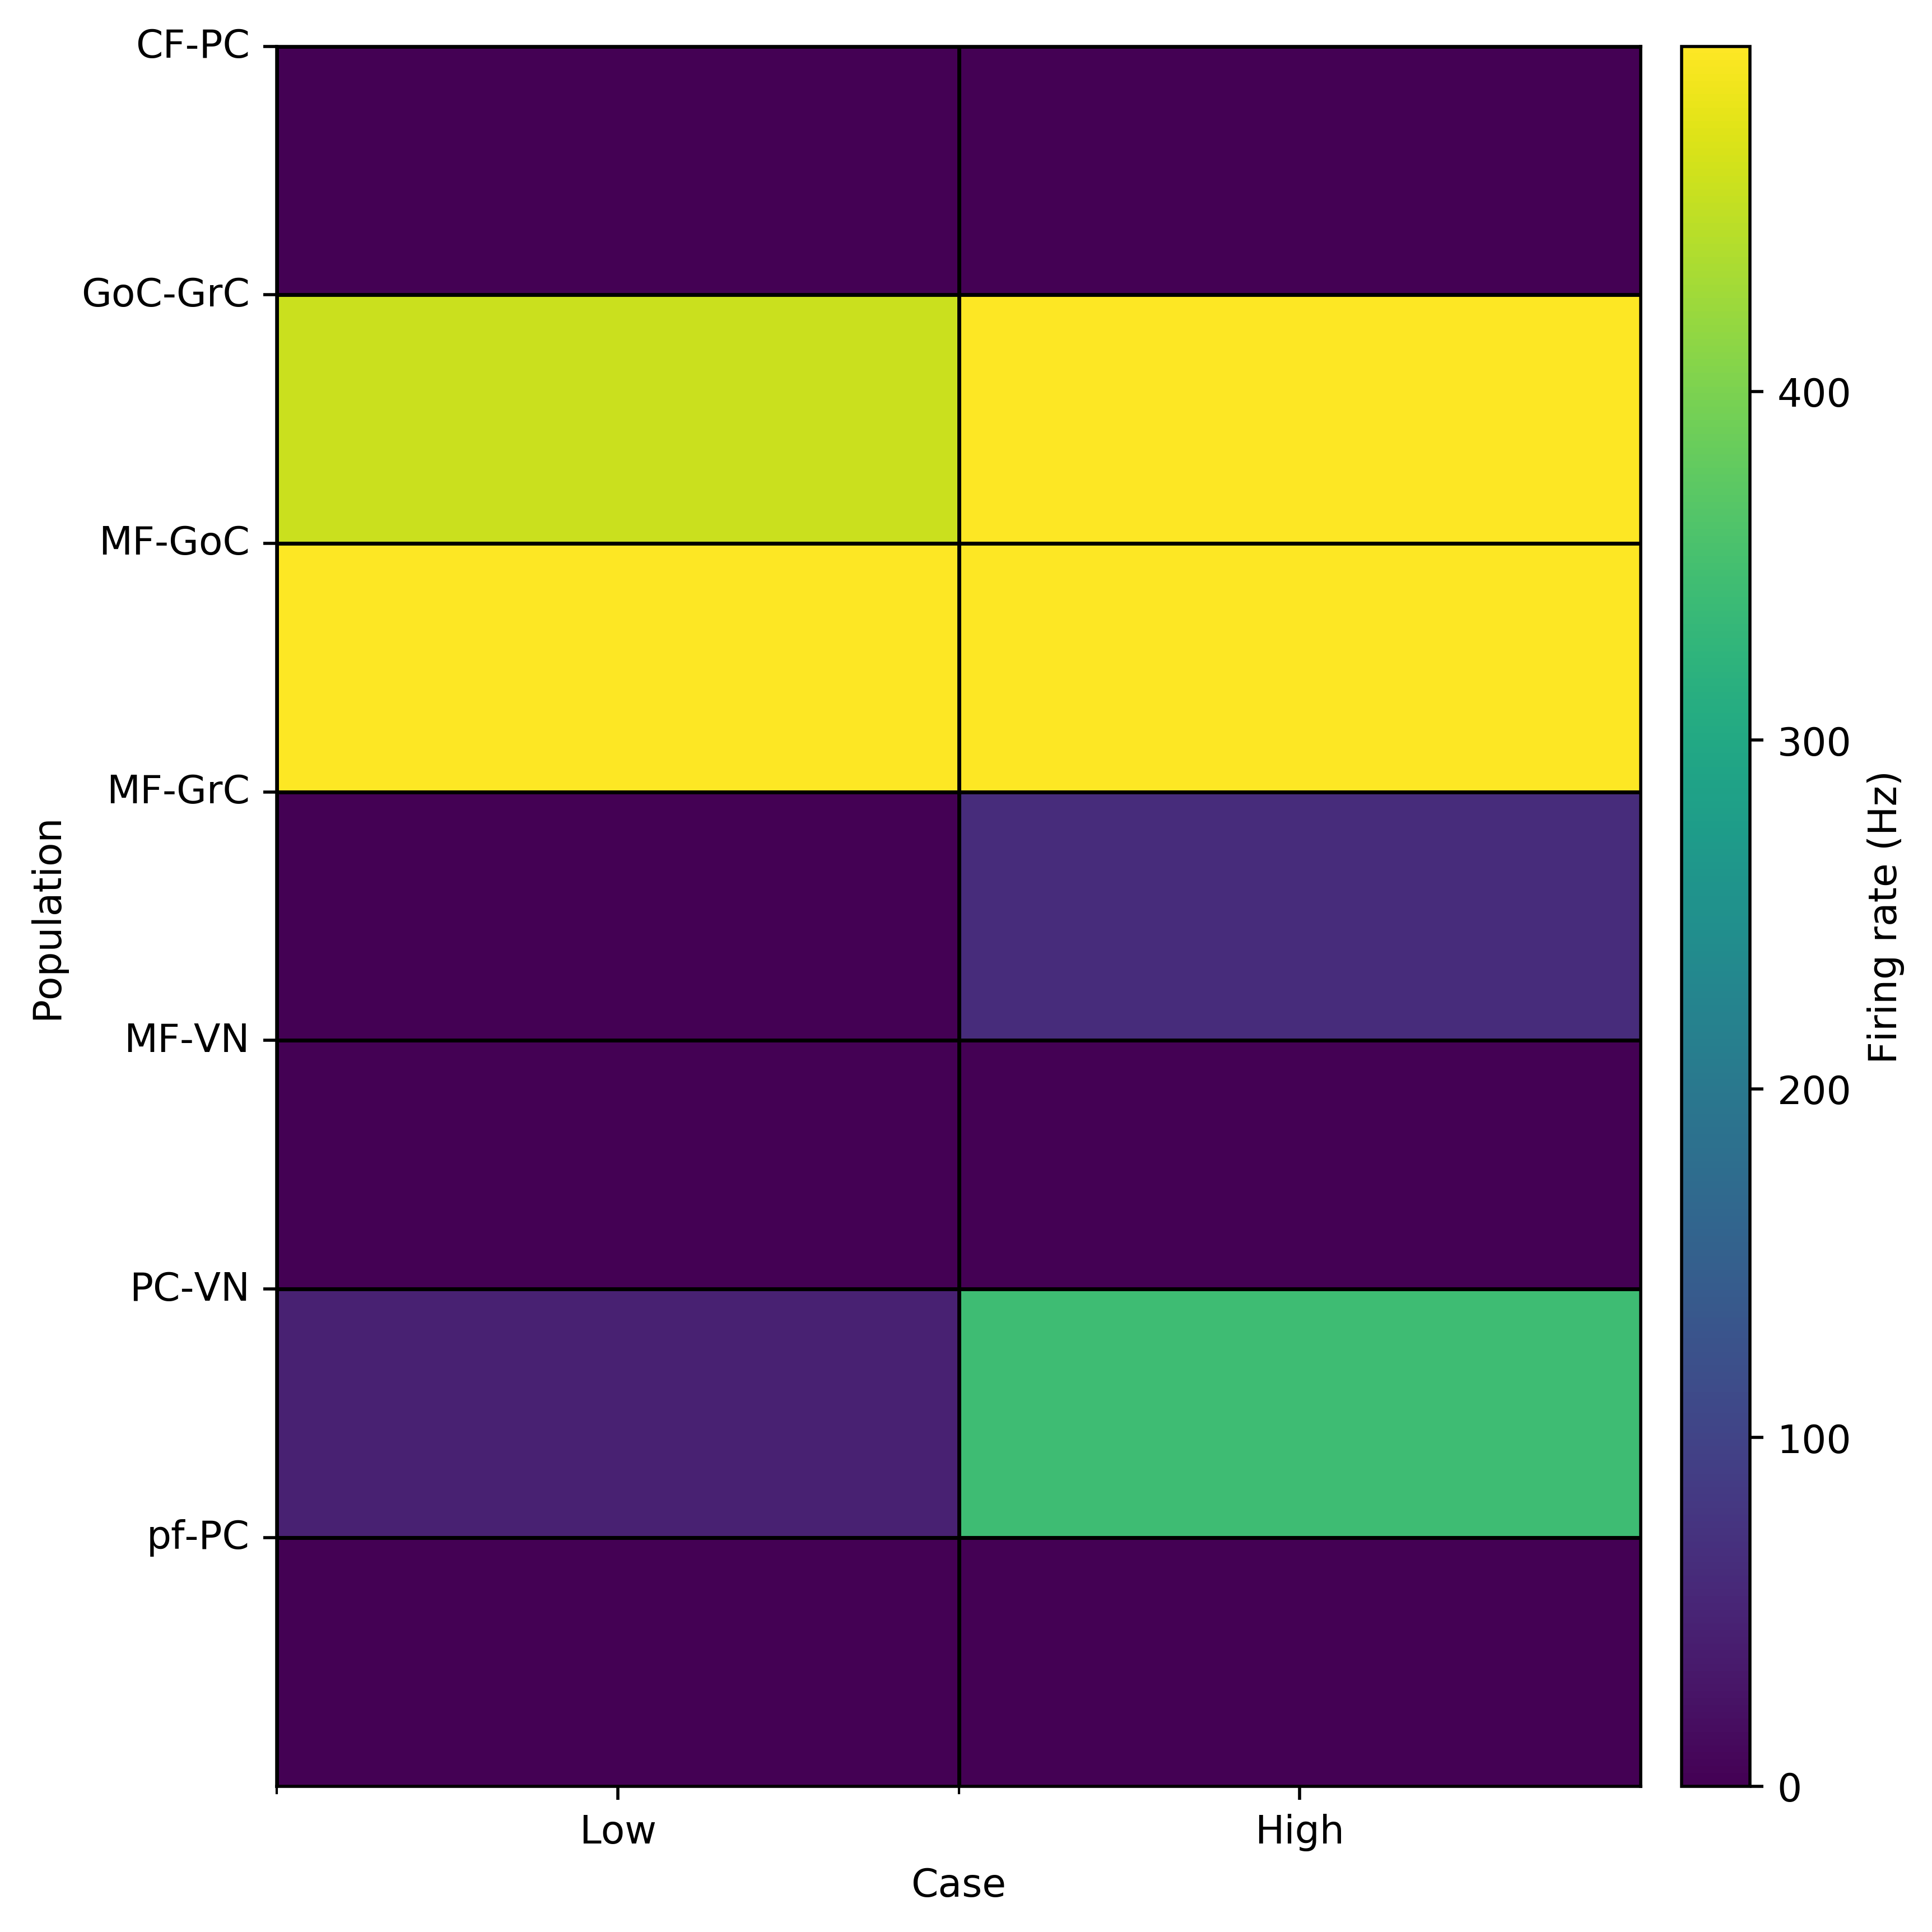

Plotting                                :figures/ICUB_VOR_baseline_isi_map_spikes.png
Plotting                                :figures/ICUB_VOR_baseline_isi_map_spikes.pdf


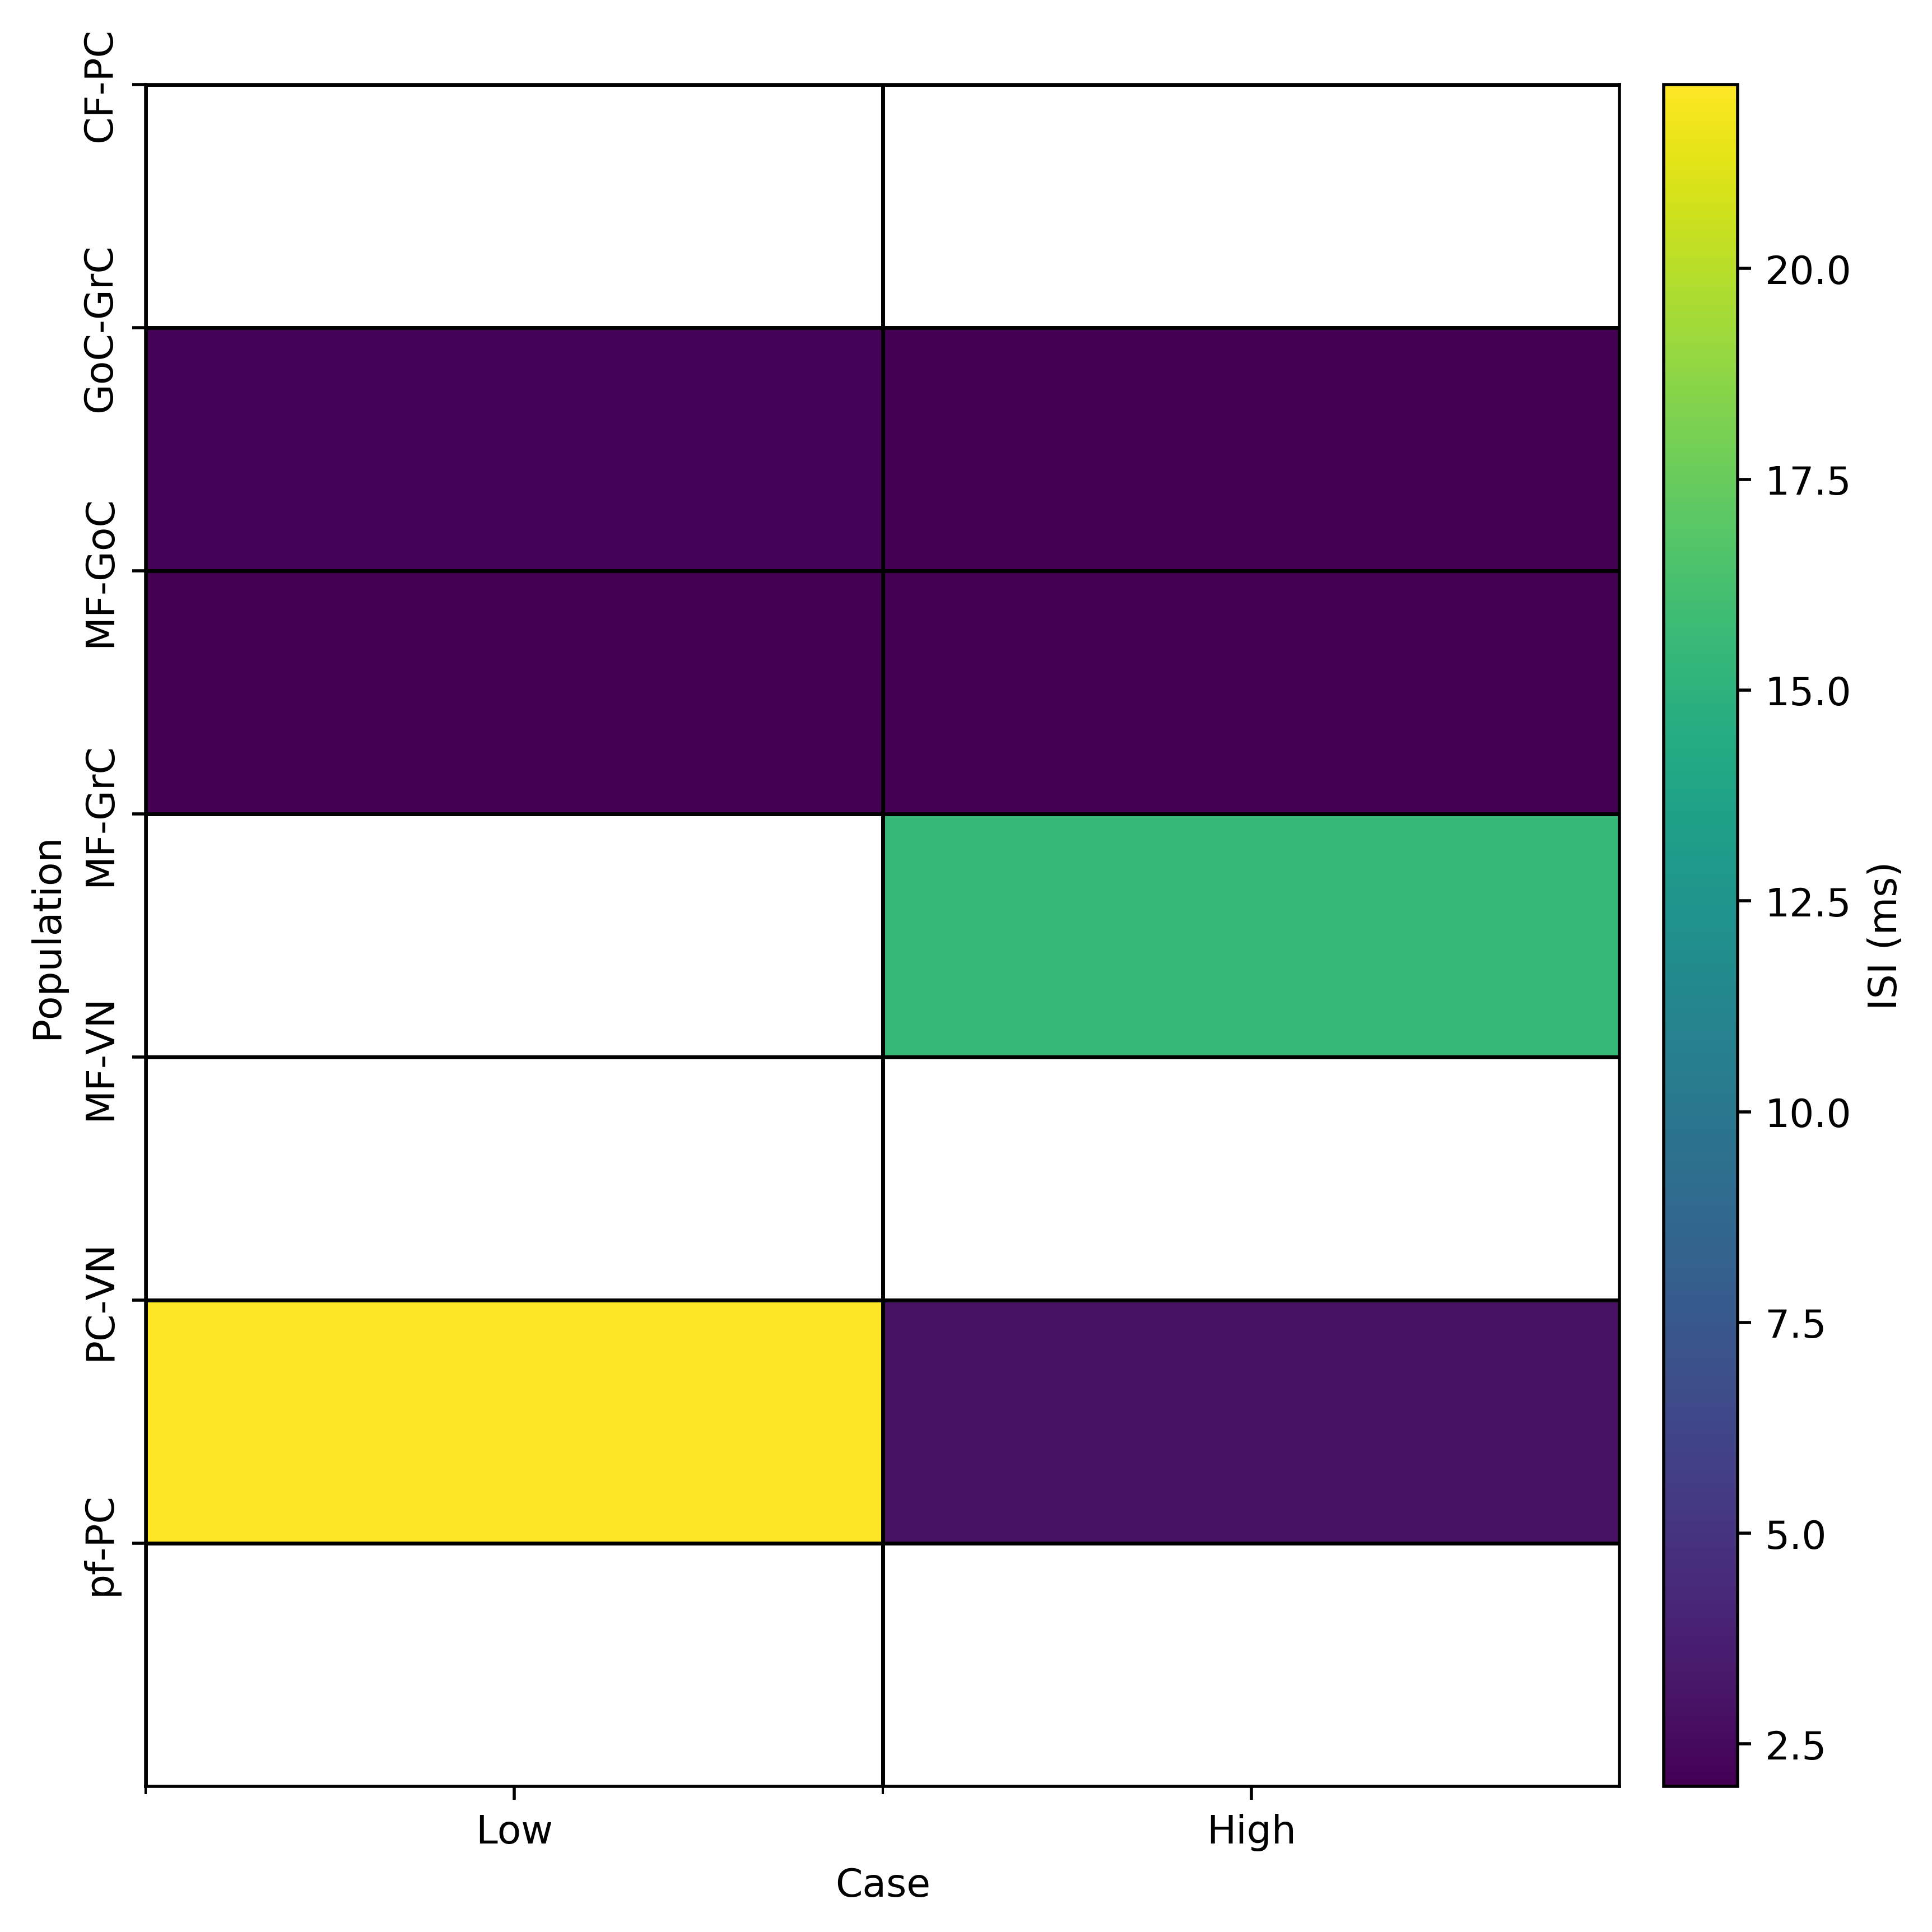

In [237]:
x = spike_count_map_baseline / (simtime * ms) 
plot_imshow_diff_map(x/Hz, plot_order, cases, [1], "Case", "Firing rate (Hz)", 
                     "ICUB_VOR_spikes_baseline_firing_rate_map", 
                     fig_folder, 
#                      vmax=max_firing_rate, 
                     rotation=0)
plot_imshow_diff_map(baseline_isi_map, plot_order, cases, [1], 
                     "Case", "ISI (ms)", "ICUB_VOR_baseline_isi_map_spikes",  
                     fig_folder)

Plotting                                :figures/ICUB_VOR_spikes_firing_rate_map.png
Plotting                                :figures/ICUB_VOR_spikes_firing_rate_map.pdf


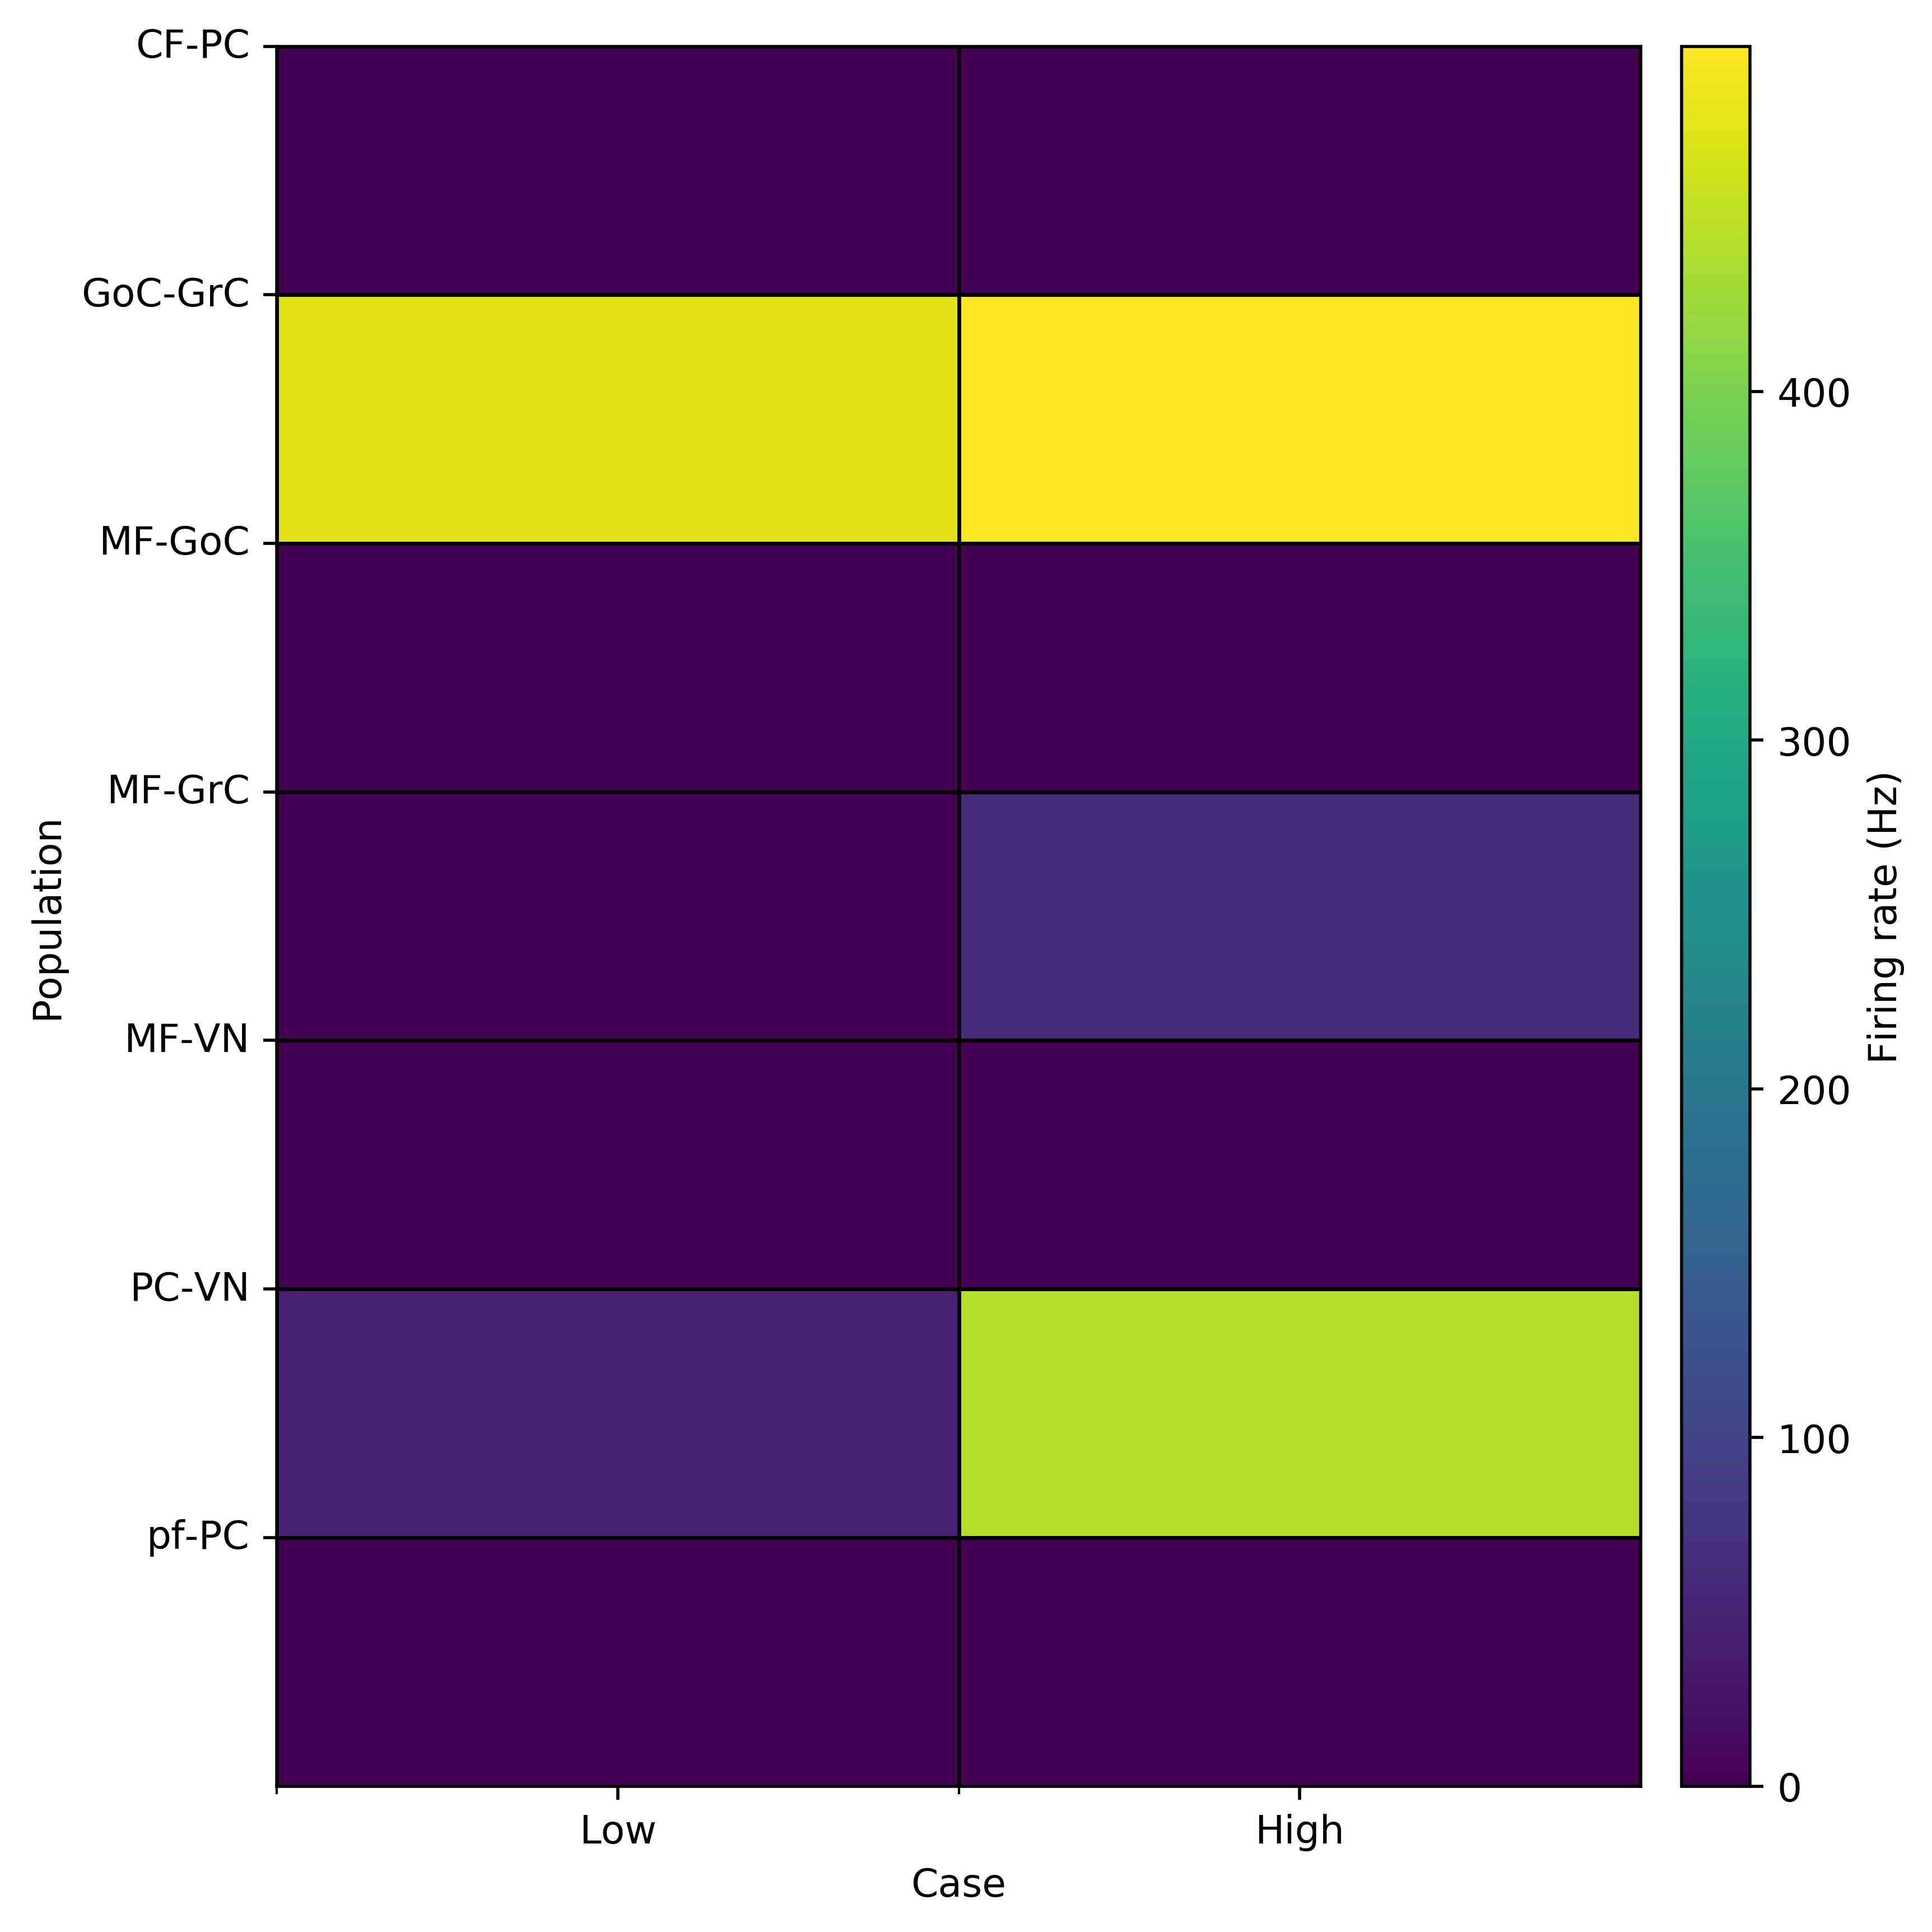

Plotting                                :figures/ICUB_VOR_isi_map_spikes.png    
Plotting                                :figures/ICUB_VOR_isi_map_spikes.pdf    


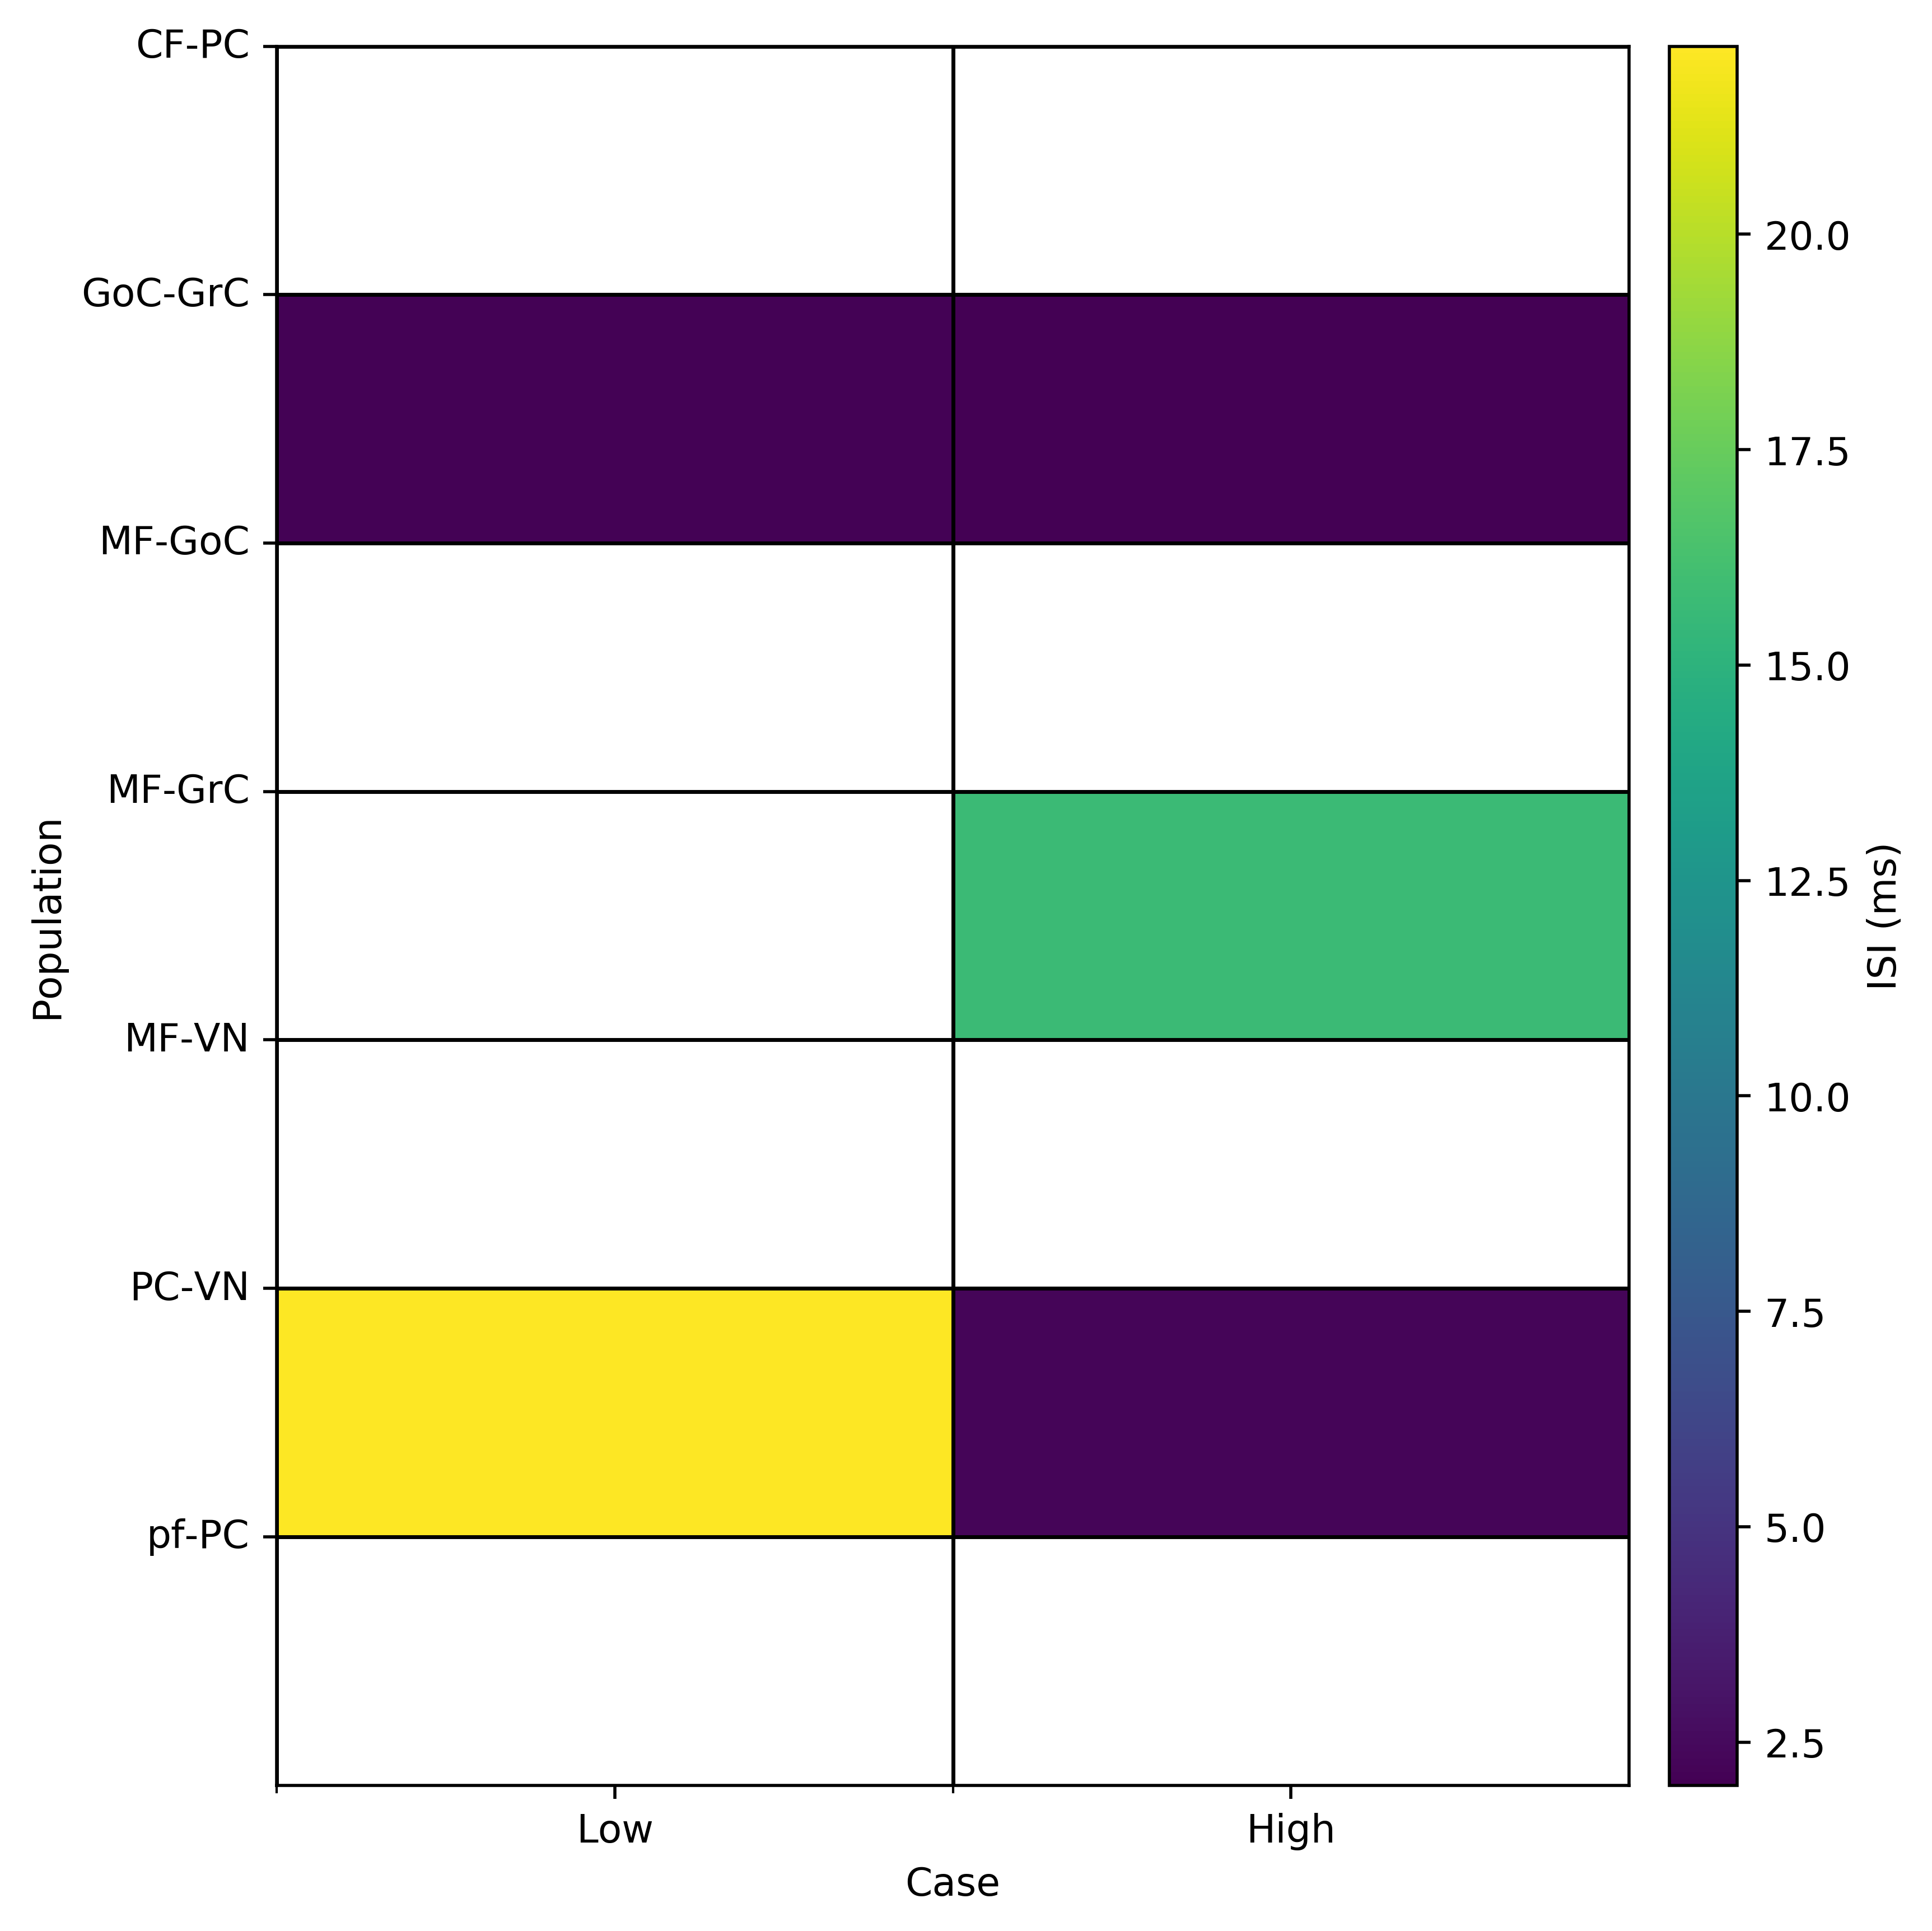

In [238]:
x2 = spike_count_map / (simtime * ms) 
plot_imshow_diff_map(x2/Hz, plot_order, cases, [1], 
                     "Case", "Firing rate (Hz)", "ICUB_VOR_spikes_firing_rate_map", 
                     fig_folder, vmax=max_firing_rate, rotation=0)
plot_imshow_diff_map(isi_map, plot_order, cases, [1], 
                     "Case", "ISI (ms)", "ICUB_VOR_isi_map_spikes",  
                     fig_folder, rotation=0)

Plotting                                :figures/ICUB_VOR_spikes_count_difference.png
Plotting                                :figures/ICUB_VOR_spikes_count_difference.pdf


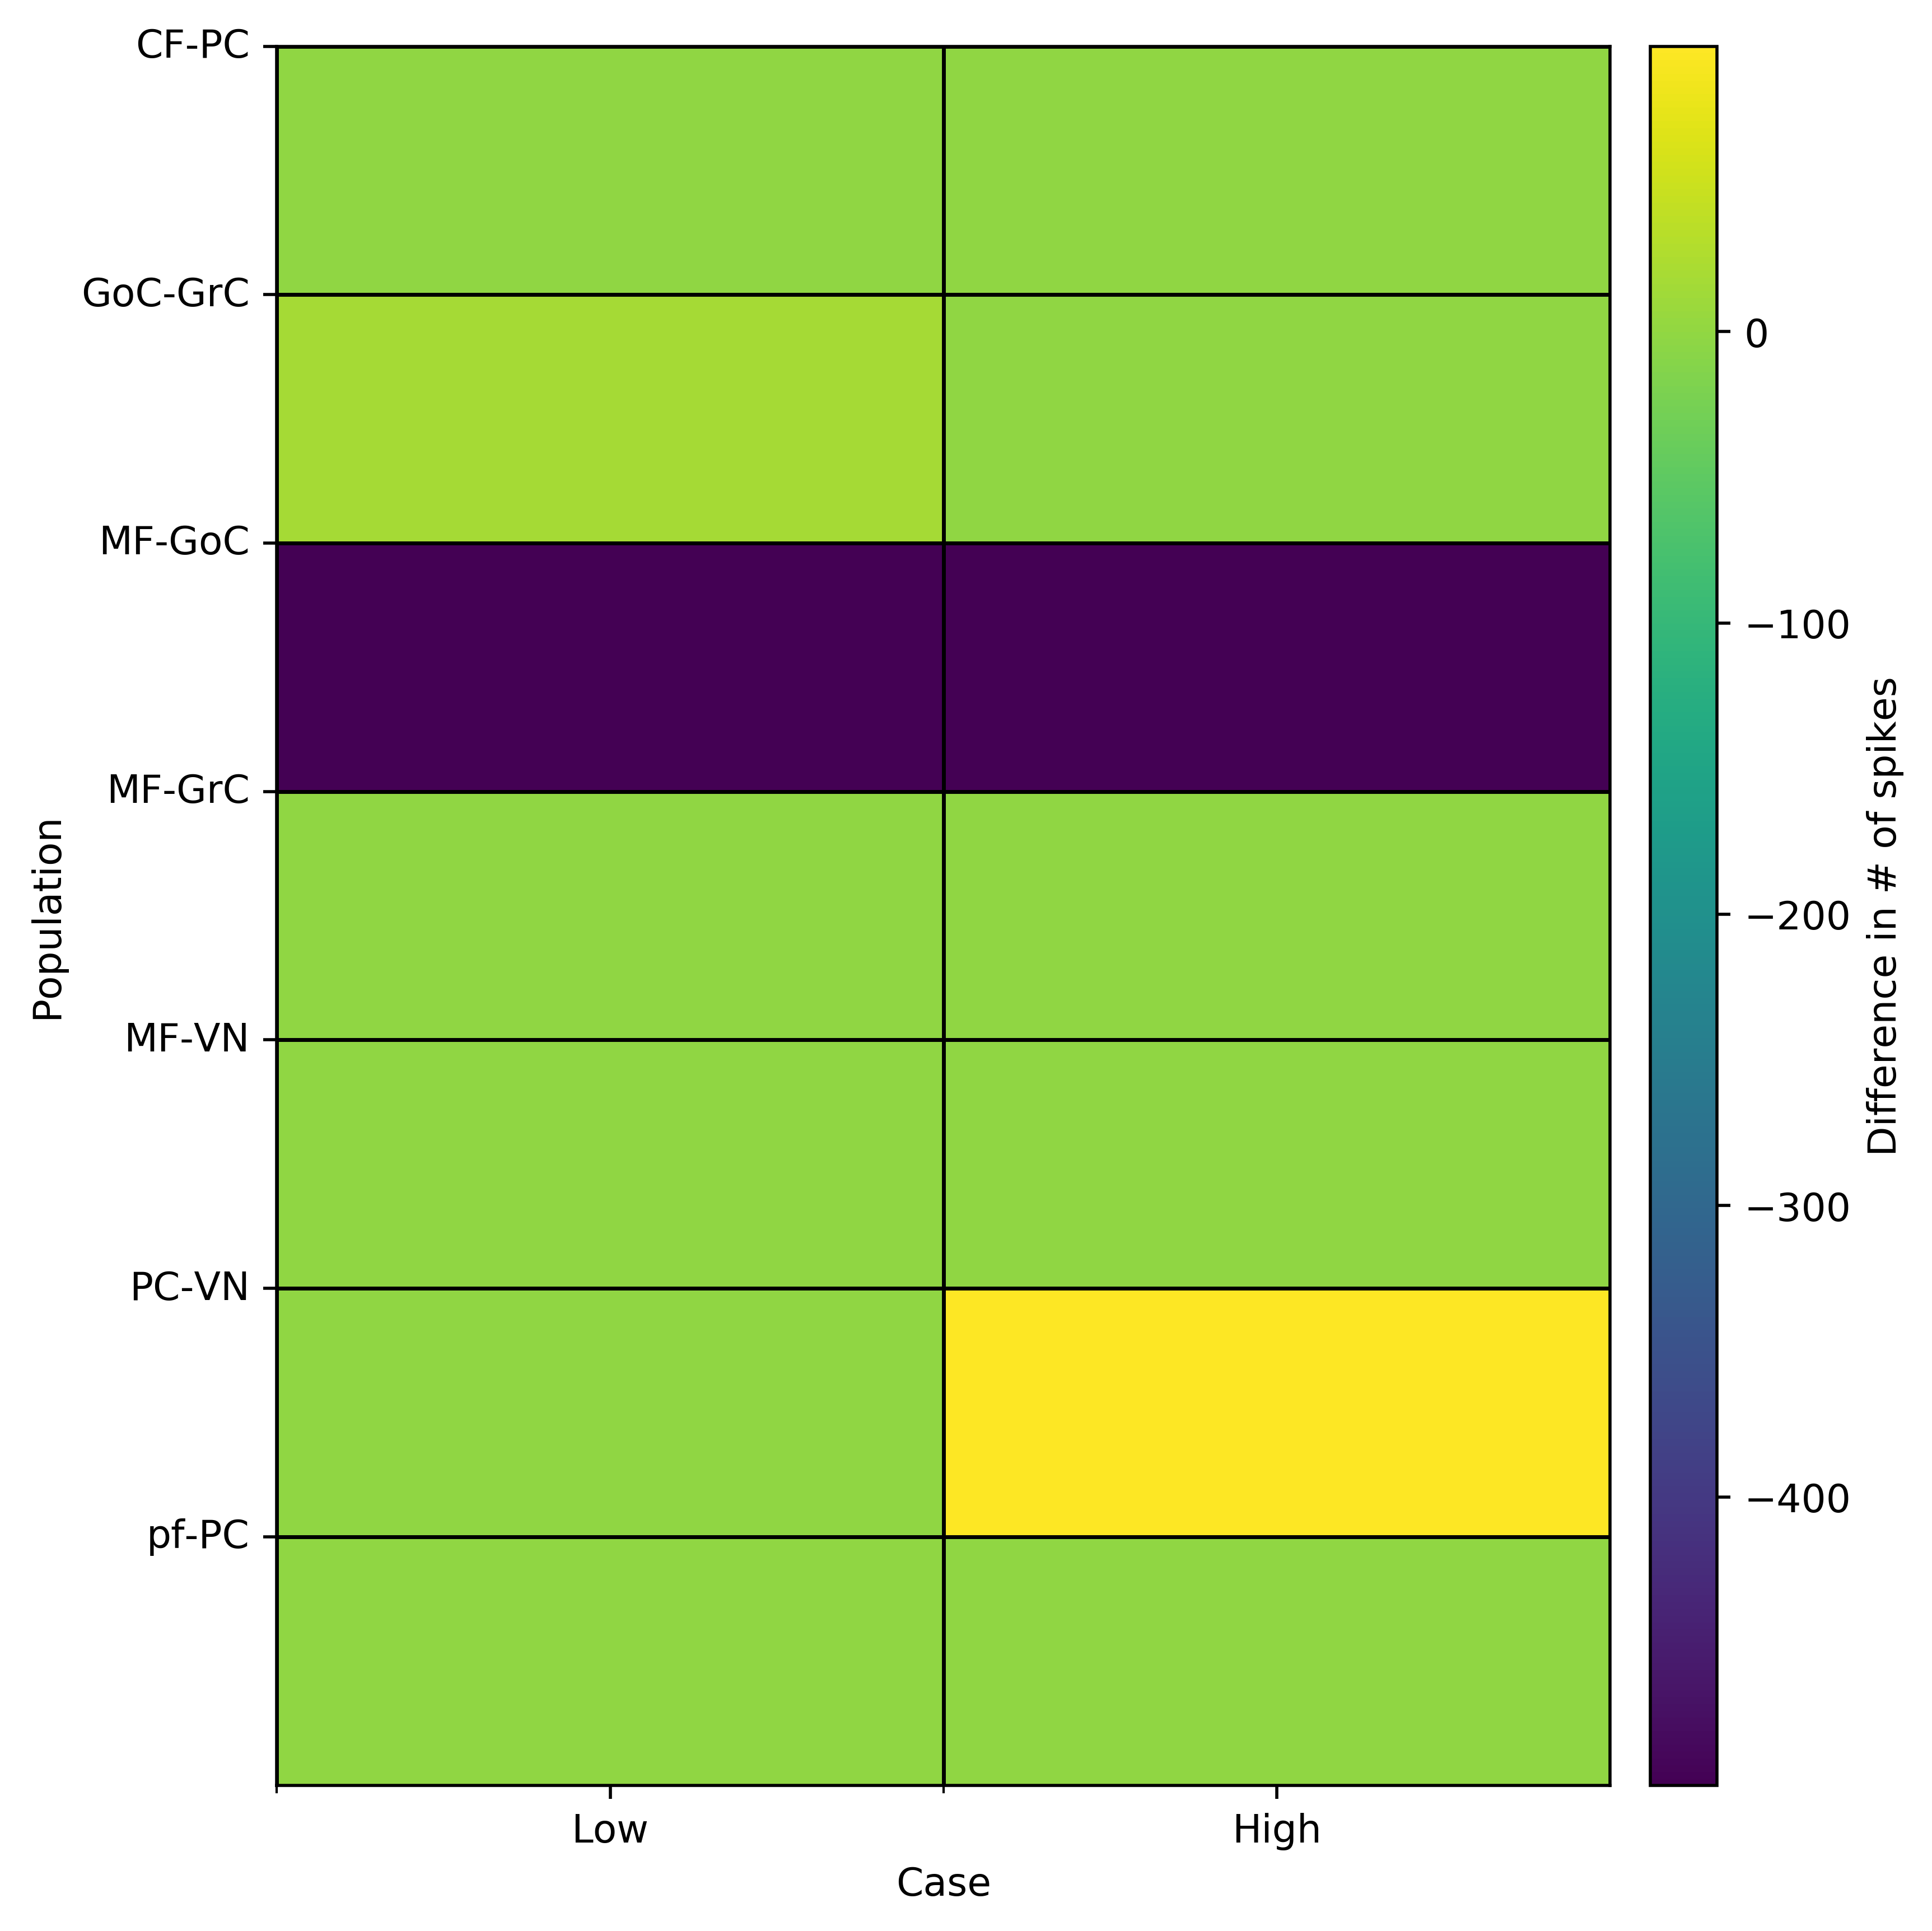

Plotting                                :figures/ICUB_VOR_isi_difference_spikes.png
Plotting                                :figures/ICUB_VOR_isi_difference_spikes.pdf


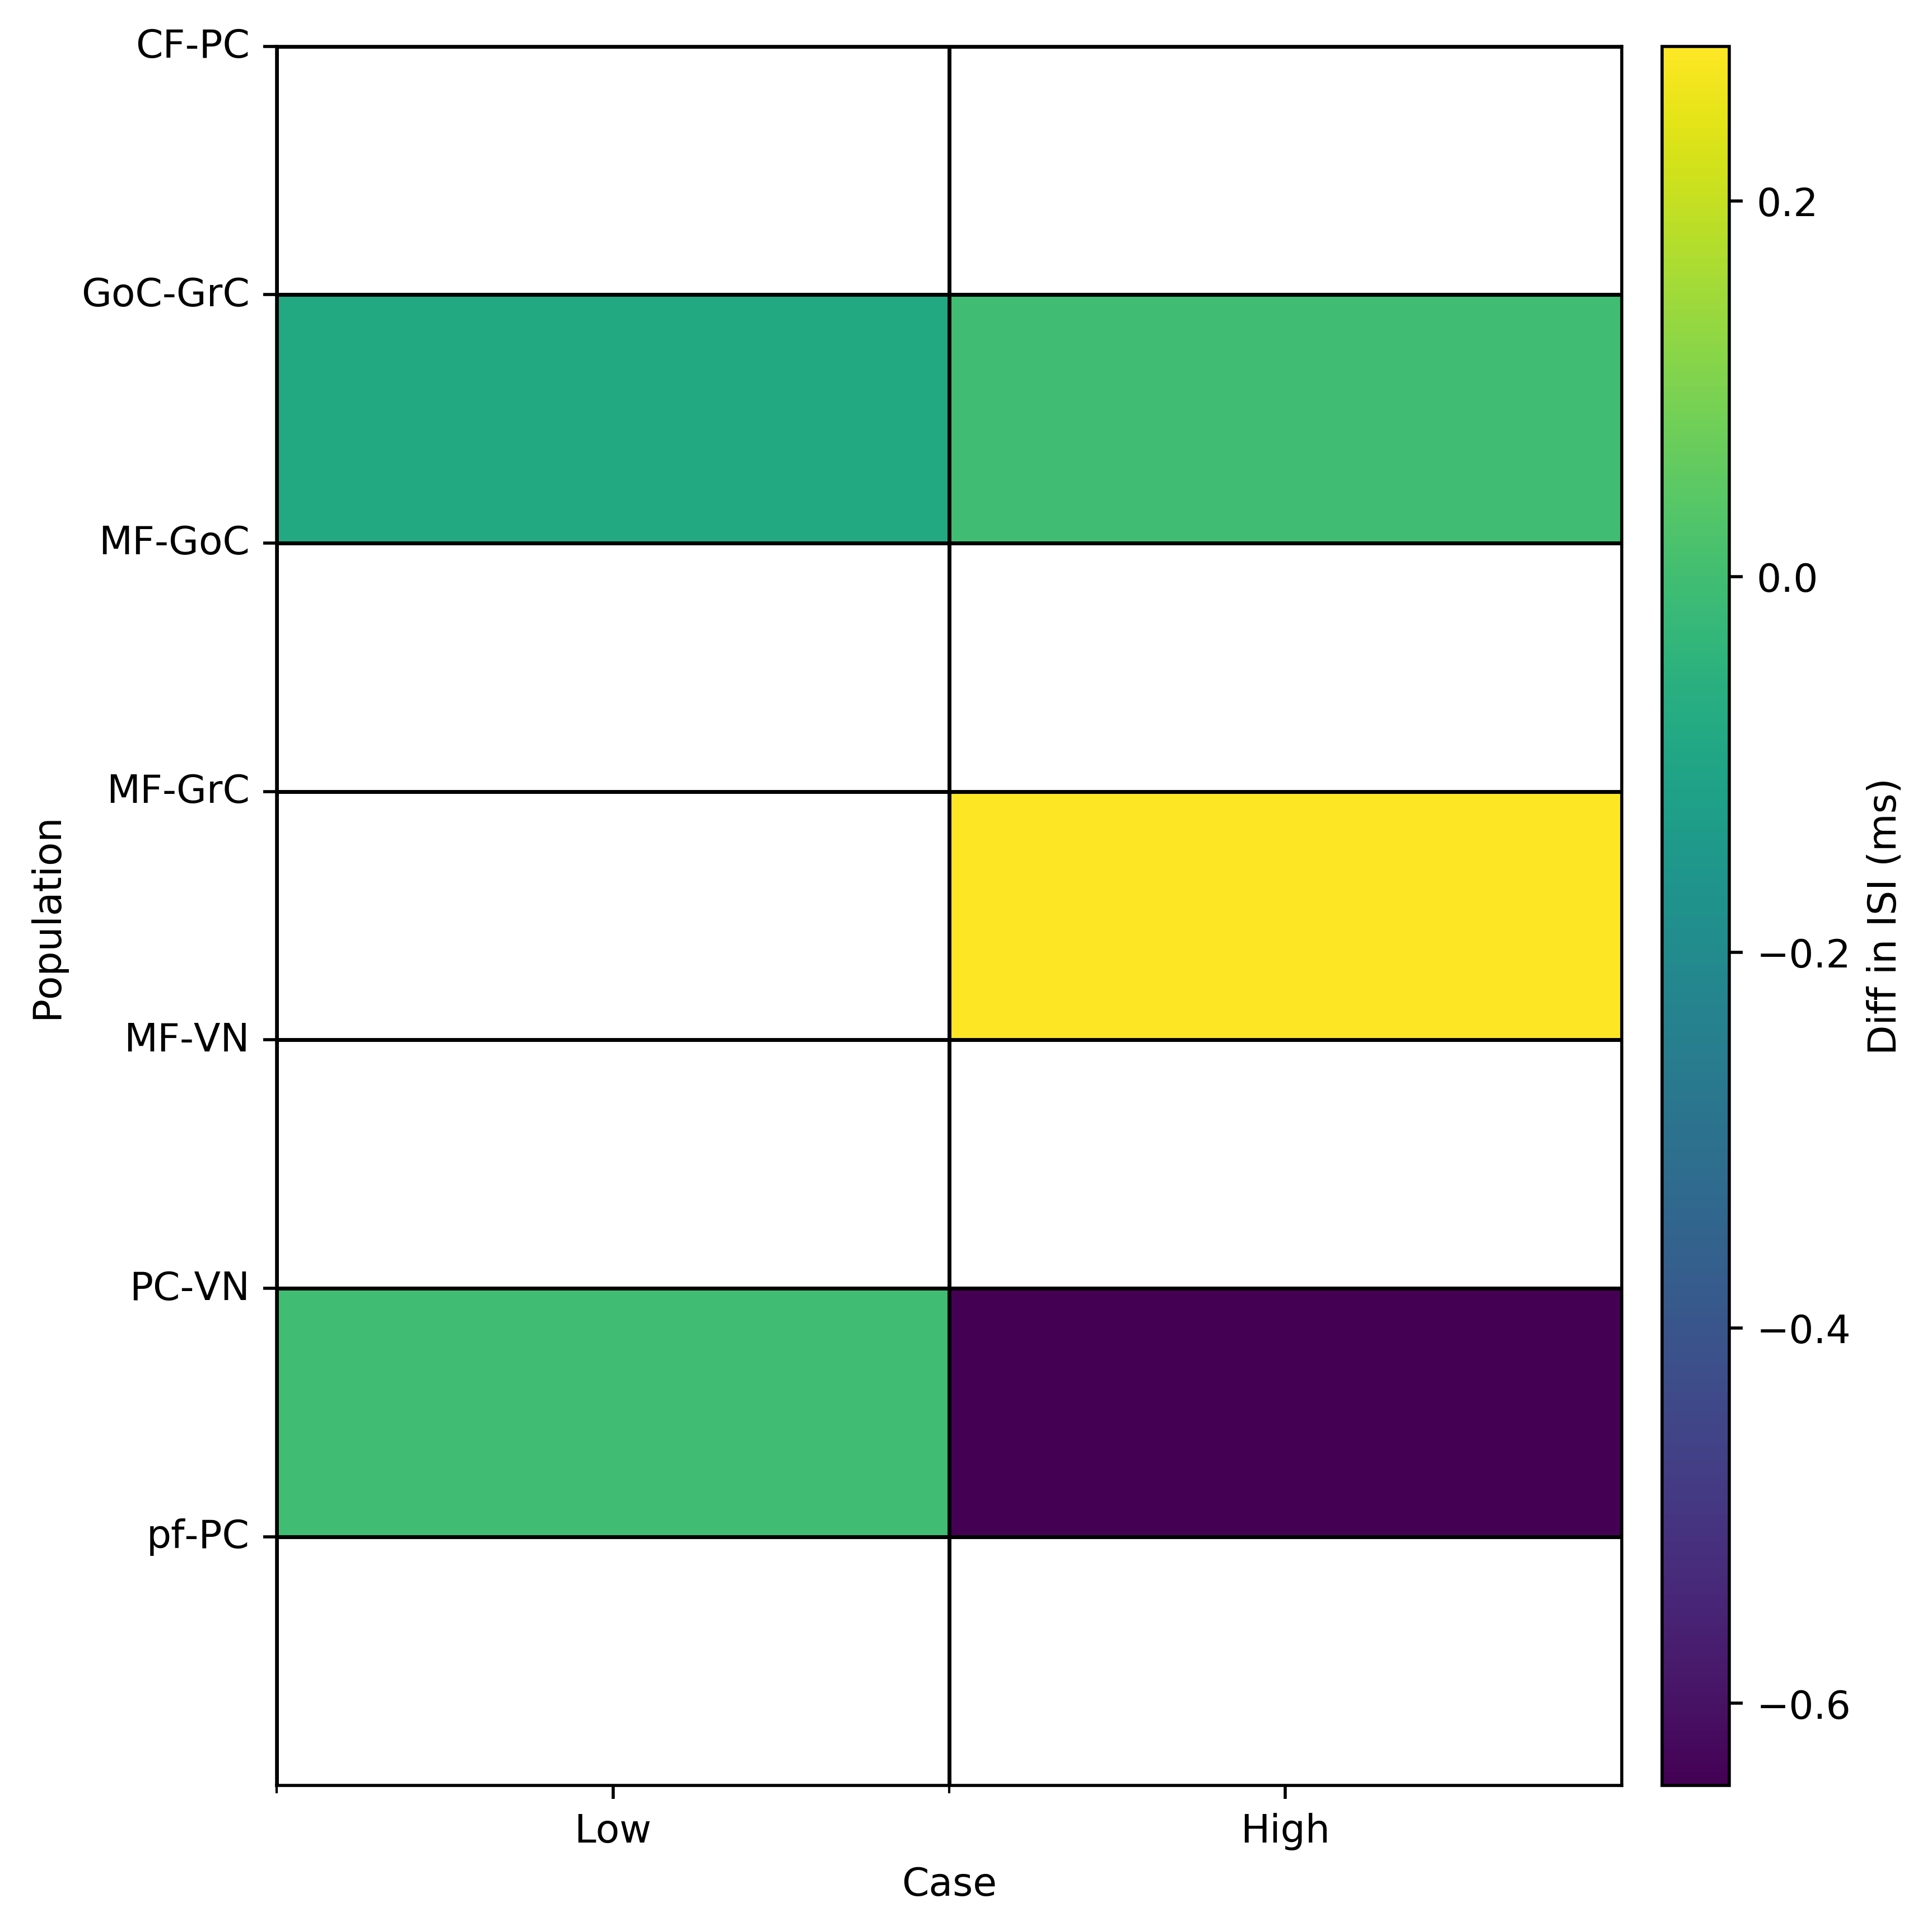

In [239]:
plot_imshow_diff_map(diff_map, plot_order, cases, [1], "Case", 
                     "Difference in # of spikes", "ICUB_VOR_spikes_count_difference", 
                     fig_folder, rotation=0, 
#                      vmax=20, vmin=-20
                    )

plot_imshow_diff_map(diff_isi_map, plot_order, cases, subcycles, 
                     "Case", "Diff in ISI (ms)", "ICUB_VOR_isi_difference_spikes", 
                     fig_folder, rotation=0)

In [240]:
spike_lead_lag_map_10th*ms

array([[ nan,  nan],
       [-0.9, -0.9],
       [ nan,  nan],
       [ nan,  1.1],
       [ nan,  nan],
       [-0.9, -3.9],
       [ nan,  nan]]) * msecond

In [241]:
spike_lead_lag_map_1st*ms

array([[ nan,  nan],
       [-0.9, -0.9],
       [ nan,  nan],
       [ nan, -0.9],
       [ nan,  nan],
       [-0.9,  0.1],
       [ nan,  nan]]) * msecond

In [242]:
spike_lead_lag_map_100th*ms

array([[  nan,   nan],
       [-11.9,  -0.9],
       [  nan,   nan],
       [  nan,   nan],
       [  nan,   nan],
       [  nan, -62.9],
       [  nan,   nan]]) * msecond

Plotting                                :figures/spikes_1st_spike_lead_lag_map.png
Plotting                                :figures/spikes_1st_spike_lead_lag_map.pdf


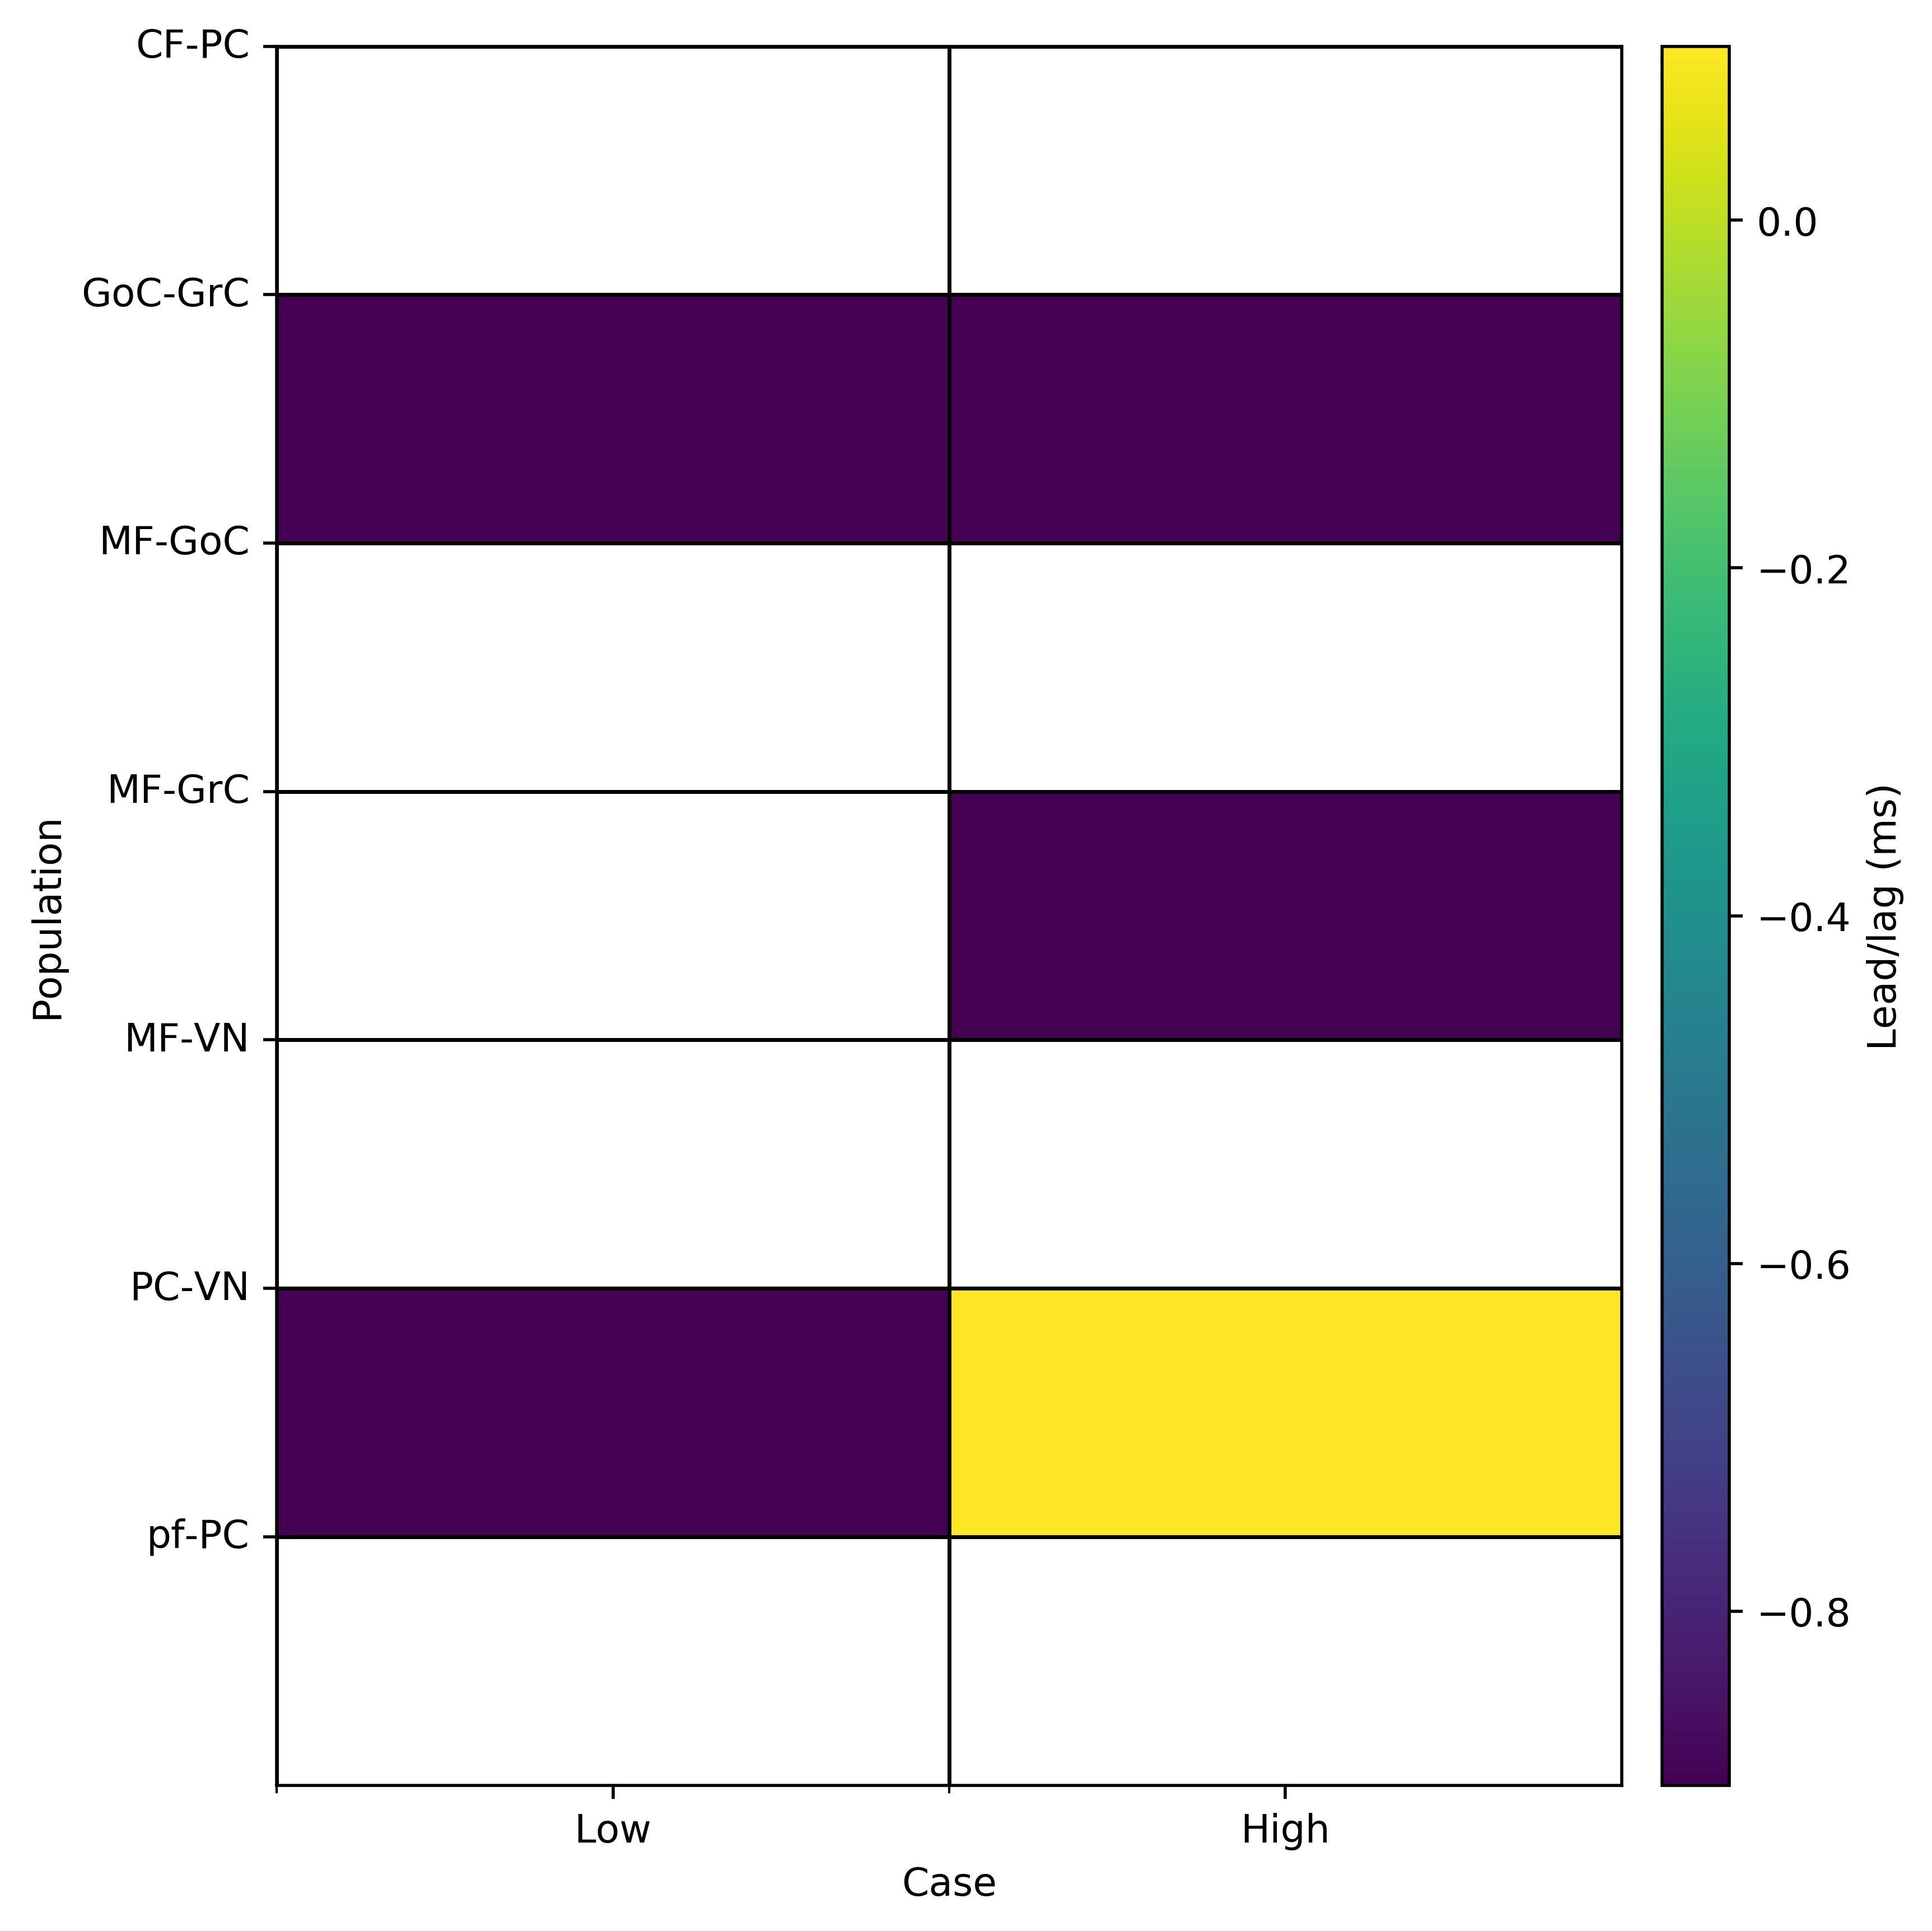

In [243]:
plot_imshow_diff_map(spike_lead_lag_map_1st, plot_order, 
#                      np.array([0, 1]), 
                     cases,                     
                     subcycles, "Case", "Lead/lag (ms)", "spikes_1st_spike_lead_lag_map", fig_folder, rotation=0, 
#                      vmax=5, vmin=-5
                    )


Plotting                                :ICUB_VOR_single_vs_max_spikes.png      
Plotting                                :ICUB_VOR_single_vs_max_spikes.pdf      


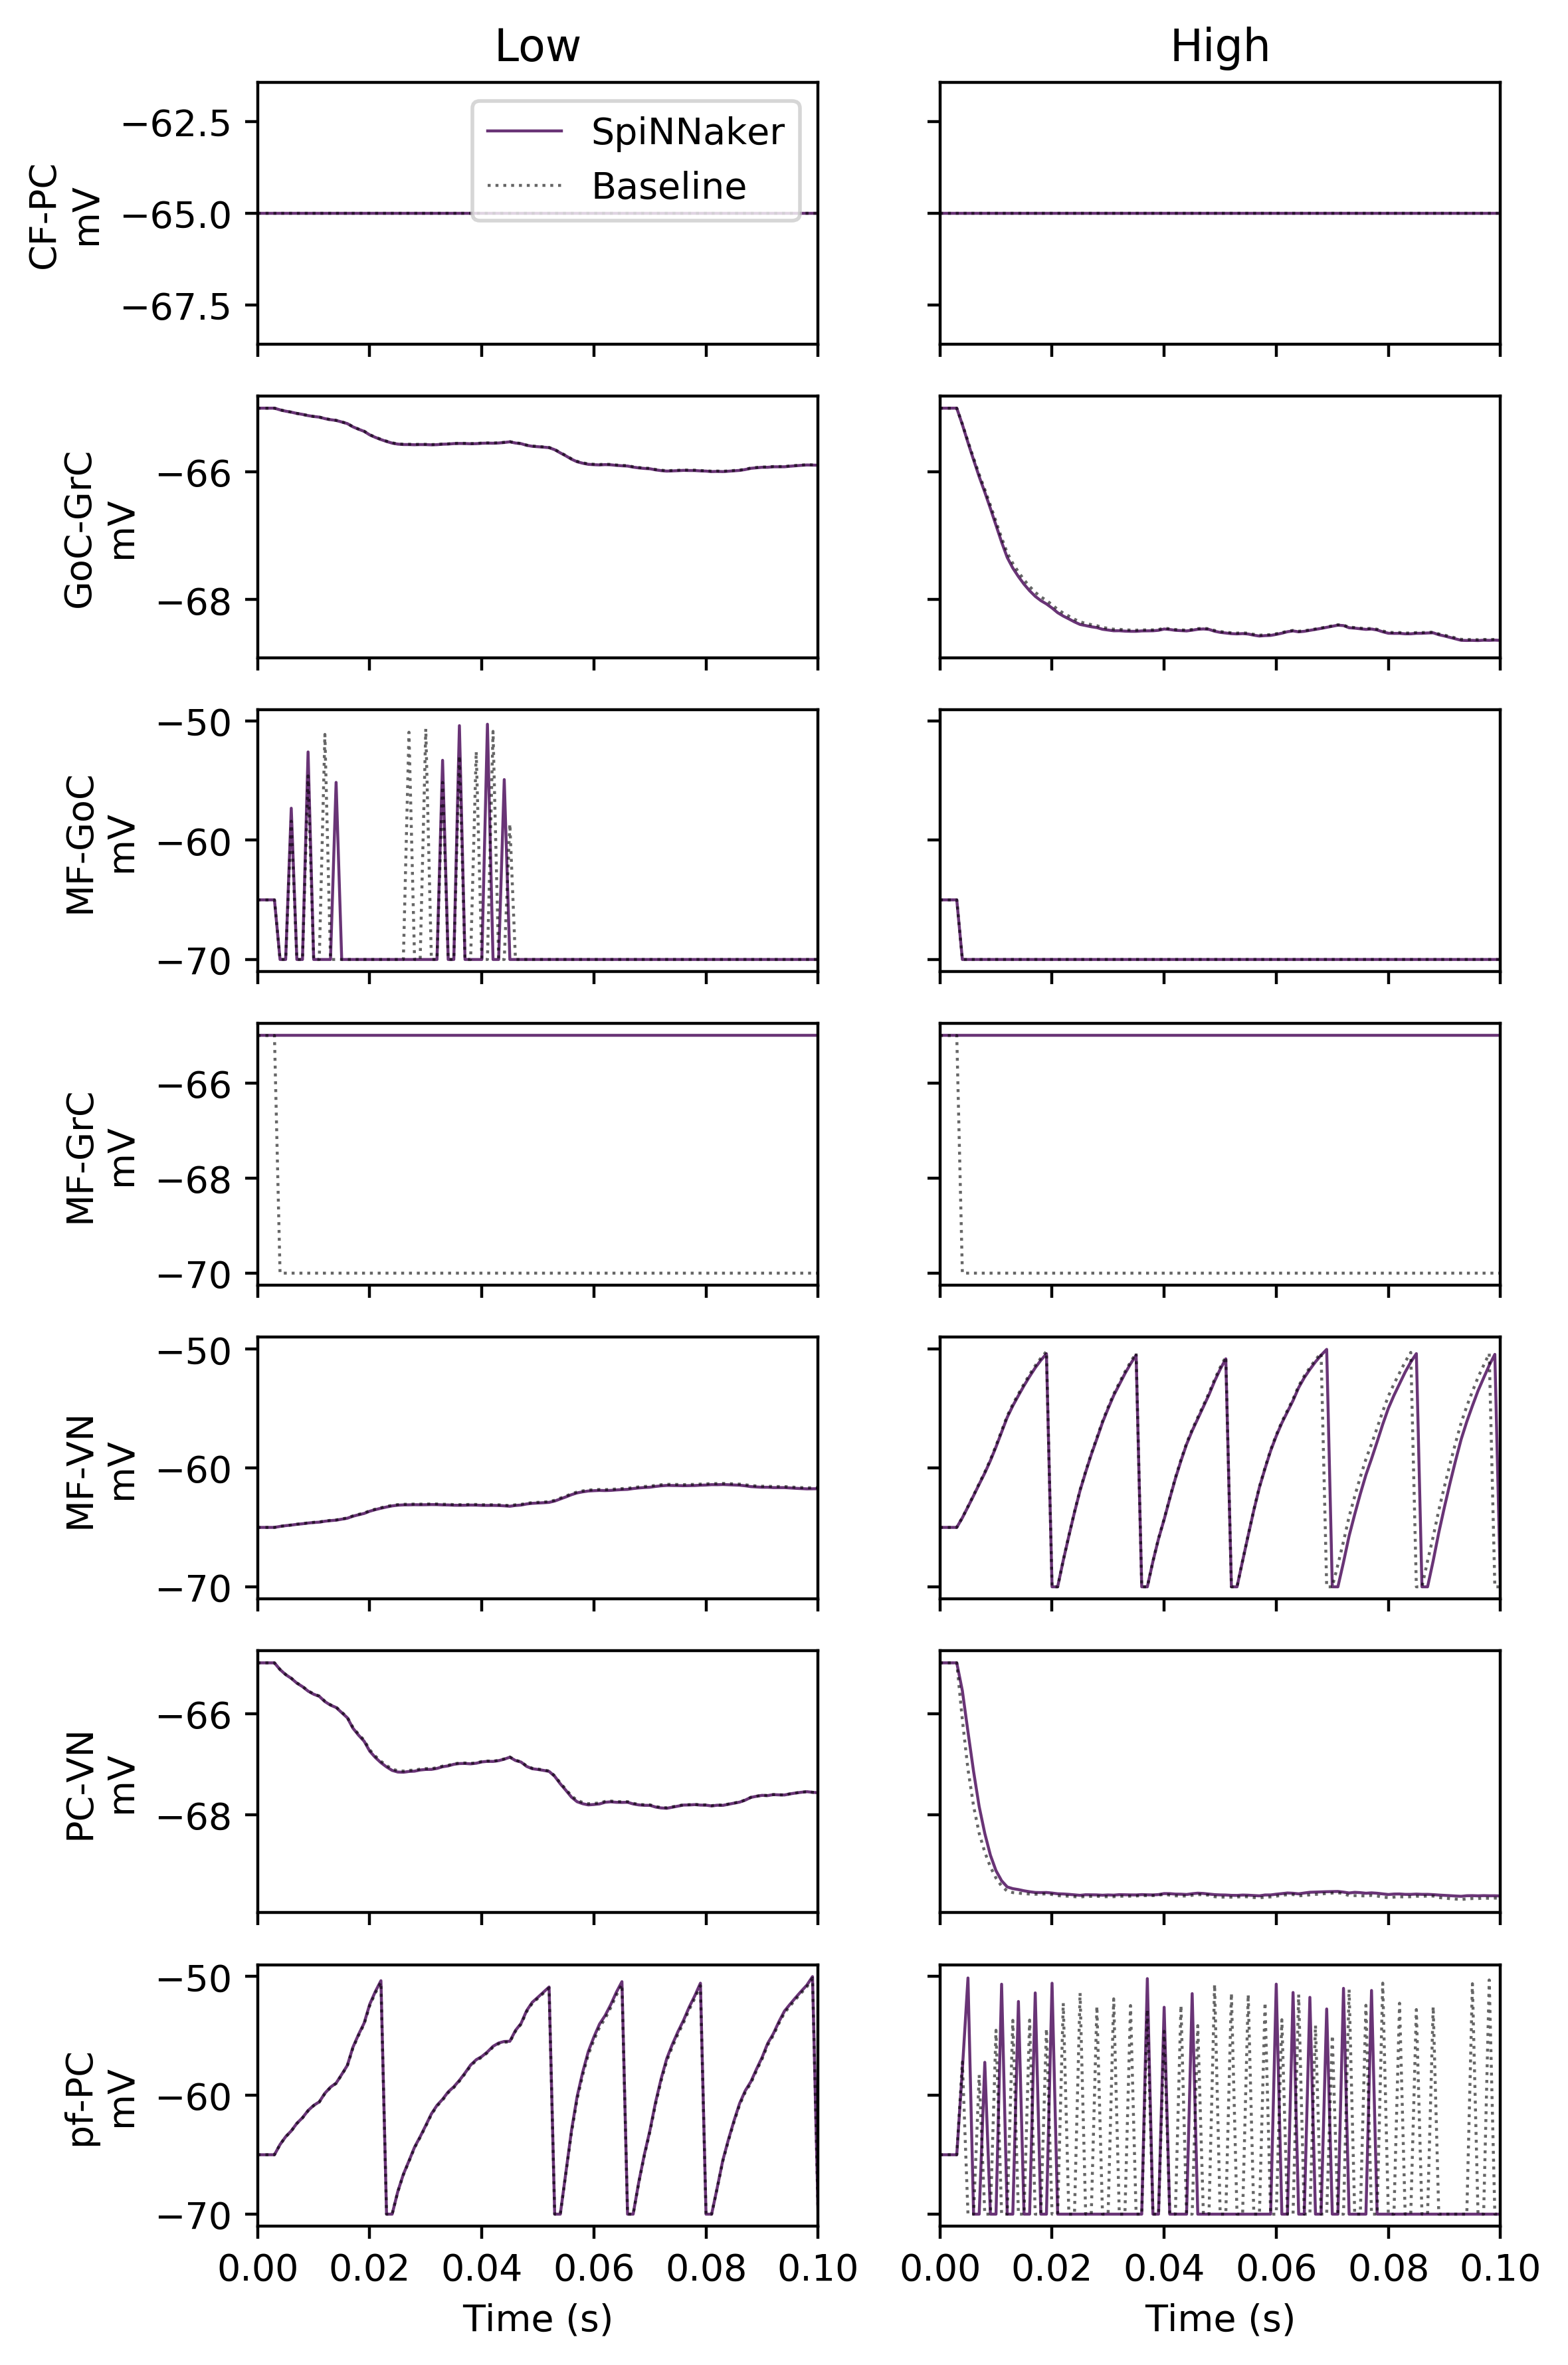

In [244]:
plot_by_case(vs, baseline_vs, plot_order, [1], cases=[0, 1], y_label="mV", # xlim=[7.3, 7.5]
            )

In [245]:
all_connections[1]['mf_goc']

array([[ 0.       ,  0.       ,  0.1000061,  1.       ],
       [ 1.       ,  0.       ,  0.1000061,  1.       ],
       [ 2.       ,  0.       ,  0.1000061,  1.       ],
       [ 3.       ,  0.       ,  0.1000061,  1.       ],
       [ 4.       ,  0.       ,  0.1000061,  1.       ],
       [ 5.       ,  0.       ,  0.1000061,  1.       ],
       [ 6.       ,  0.       ,  0.1000061,  1.       ],
       [ 7.       ,  0.       ,  0.1000061,  1.       ],
       [ 8.       ,  0.       ,  0.1000061,  1.       ],
       [ 9.       ,  0.       ,  0.1000061,  1.       ],
       [10.       ,  0.       ,  0.1000061,  1.       ],
       [11.       ,  0.       ,  0.1000061,  1.       ],
       [12.       ,  0.       ,  0.1000061,  1.       ],
       [13.       ,  0.       ,  0.1000061,  1.       ],
       [14.       ,  0.       ,  0.1000061,  1.       ],
       [15.       ,  0.       ,  0.1000061,  1.       ],
       [16.       ,  0.       ,  0.1000061,  1.       ],
       [17.       ,  0.       ,

In [252]:
no_packets[1]['pf_pc'].shape

(1, 1000)

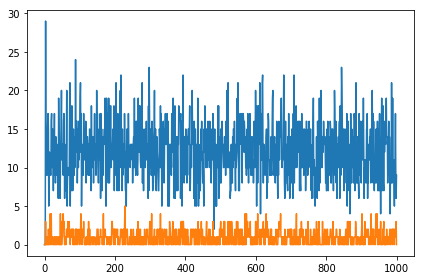

In [254]:
plt.plot(no_packets[1]['pf_pc'][0])
plt.plot(no_packets[0]['pf_pc'][0])

In [248]:
no_packets[1]['pf_pc']

array([[ 0,  0,  0, 29, 11,  9, 10,  9, 14, 16, 17, 15,  5,  9, 12, 11,
        11,  9,  9, 16, 17, 10, 12, 15, 13,  7, 13, 11, 17,  9, 13,  8,
        14, 11, 11,  9, 13, 11,  9,  6, 19, 14, 10, 12,  6,  9, 13, 15,
        20, 11, 11, 13, 11,  9, 16, 17, 13,  6, 13,  7,  9,  8, 13, 20,
         5,  8, 10,  9,  9,  9,  9, 17, 21,  5, 13, 12,  7, 18, 18, 13,
         7, 11, 15, 10,  9, 14, 10, 12, 24, 12, 16, 16, 16,  8, 12, 15,
        10, 16, 11, 16, 15, 19, 21, 12, 17,  5, 11, 12, 13,  9,  9, 17,
        14, 15, 11, 13, 11, 16,  8, 11, 12, 14, 14, 13,  9, 13, 12,  9,
        15,  9, 12,  9,  7, 18, 12, 12, 10, 14, 12,  8, 11, 13, 17, 11,
        13, 12,  9, 10, 20, 13, 17, 12, 10,  8, 12, 15, 13, 11, 17,  6,
        17, 11, 15,  7, 10, 13,  9, 14, 13, 14, 15, 13, 19, 12,  5,  5,
        19, 16, 11, 17, 11,  8, 19, 11,  8, 10, 11, 18, 18, 10, 11, 13,
        13, 13, 15, 11, 12, 18,  7, 14,  9, 12, 13, 21, 14,  9,  7,  8,
        17,  8, 11,  7, 14, 13, 17, 20, 10, 22, 11, 13,  7, 15, 